In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy
from itertools import islice
import skimage

In [2]:
def get_gaussian_pyramid(image, levels=5):
    # Ref: https://docs.opencv.org/3.1.0/dc/dff/tutorial_py_pyramids.html
    pyramid = [image]
    for i in range(levels):
        width, height = pyramid[i].shape[1], pyramid[i].shape[0]
        pyramid.append(cv2.pyrDown(pyramid[i], dstsize=(width // 2, height // 2)))
    return pyramid


def get_laplacian_pyramid(image, levels=5):
    # Ref: https://docs.opencv.org/3.1.0/dc/dff/tutorial_py_pyramids.html
    gaussian_pyramid = get_gaussian_pyramid(image, levels - 1)
    res = []

    for i in range(levels - 1):
        width, height = gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0]
        res.append(gaussian_pyramid[i] -
                   cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=(width, height)))
    res.append(gaussian_pyramid[levels - 1])
    return res

def get_riesz_pyramid(image, levels=5):
    # Get a grayscale image
    assert image.ndim == 2
    
    kernel_x = np.array([[0.0, 0.0, 0.0],
                         [0.5, 0.0, -0.5],
                         [0.0, 0.0, 0.0]])
    kernel_y = np.array([[0.0, 0.5, 0.0],
                         [0.0, 0.0, 0.0],
                         [0.0, -0.5, 0.0]])
    laplacian_pyramid = get_laplacian_pyramid(image, levels + 1)
    
    # Ignore the last level which is just the low-pass residual
    riesz_x = [scipy.ndimage.filters.convolve(laplacian_pyramid[level], kernel_x)
               for level in range(levels)]
    riesz_y = [scipy.ndimage.filters.convolve(laplacian_pyramid[level], kernel_y)
               for level in range(levels)]
    
    return laplacian_pyramid, riesz_x, riesz_y, laplacian_pyramid[-1]

def get_phase_difference_and_amplitude(a_prev, b_prev, c_prev, a_curr, b_curr, c_curr):
    # Quaternion representation here = a + b * i + c * j + 0 * k
    # We want to find phase difference between q_prev and q_curr
    # So we calculate q_curr / q_prev = q_curr * conjugate(q_prev) / | q_prev | ^2
    # Phase difference is invariant to scale so we just find phase difference
    # using q_curr * conjugate(q_prev) = p
    p_real = (a_prev * a_curr + b_prev * b_curr + c_prev * c_curr)
    p_x = -a_curr * b_prev + a_prev * b_curr
    p_y = -a_curr * c_prev + a_prev * c_curr
    p_amplitude = (p_real ** 2 + p_x ** 2 + p_y ** 2) ** 0.5 + 1e-6
    phase_difference = np.arccos(p_real / p_amplitude)
    print("Phase difference: ", phase_difference)
    cos_orientation = p_x / (p_x ** 2 + p_y ** 2) ** 0.5
    sin_orientation = p_y / (p_x ** 2 + p_y ** 2) ** 0.5
    
    phase_difference_cos = phase_difference * cos_orientation
    phase_difference_sin = phase_difference * sin_orientation
    
    amplitude = p_amplitude ** 0.5 + 1e-6
    return phase_difference_cos, phase_difference_sin, amplitude

def amplitude_weighted_blur(filtered_phase, amplitude):
    denominator = scipy.ndimage.filters.gaussian_filter(amplitude, 2)
    numerator = scipy.ndimage.filters.gaussian_filter(filtered_phase * amplitude, 2)
    return numerator / denominator

def load_video(fname, max_frames=-1):
    """
    :param fname: Video filename
    :param max_frames: Maximum number of frames to include
    :return: Iterator that iterates over each frame in video
    """
    capture = cv2.VideoCapture(fname)

    i = 0
    while capture.isOpened():
        retval, frame = capture.read()
        if retval:
            yield (cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float64)) / 255
            # yield cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
            i += 1
        else:
            break
        if max_frames != -1 and i >= max_frames:
            break

class IdealTemporalFilter(object):
    def __init__(self, low, high):
        self.low_pass1 = None
        self.low_pass2 = None
        self._initialized = False
        self.low = low
        self.high = high
    
    def initialize(self, low_pass1, low_pass2):
        if self._initialized:
            raise ValueError("Already initialized")
        assert low_pass1.shape == low_pass2.shape
        
        self._initialized = True
        self.low_pass1 = low_pass1
        self.low_pass2 = low_pass2
        
    def filter(self, data):
        if not self._initialized:
            self.low_pass1 = data
            self.low_pass2 = data
            self._initialized = True
        else:
            self.low_pass1 = (1 - self.high) * self.low_pass1 + self.high * data
            self.low_pass2 = (1 - self.low) * self.low_pass2 + self.low * data
        return self.low_pass1 - self.low_pass2

def phase_shift(a, b, c, phase_cos, phase_sin):
    phase = (phase_cos ** 2 + phase_sin ** 2) ** 0.5
    shift_a = np.cos(phase)
    shift_b = phase_cos / phase * np.sin(phase)
    shift_c = phase_sin / phase * np.sin(phase)
    return a * shift_a - b * shift_b - c * shift_c

def get_video_details(fname):
    """
    :param fname: Video filename
    :return: FPS, Number of frames, Width, Height
    """
    capture = cv2.VideoCapture(fname)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    width, height = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(
        capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(capture.get(cv2.CAP_PROP_FPS))

    print(f"Frame count: {frame_count}, FPS: {fps}\n"
          f"Width: {width}, Height: {height}")

    return fps, frame_count, width, height

def reconstruct(laplacian_pyramid):
    res = laplacian_pyramid[-1]
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        width, height = laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0]
        res = cv2.pyrUp(res, dstsize=(width, height))
        res += laplacian_pyramid[i]

    return res

class VideoWriter(object):
    def __init__(self, out_filename, width, height):
        self.width = width
        self.height = height

        fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
        self.writer = cv2.VideoWriter(out_filename, fourcc, 30, (width, height), 0)

    def write(self, frame):
        image = (np.clip(frame, 0, 1) * 255).astype(np.uint8)
        self.writer.write(cv2.convertScaleAbs(image))

    def release(self):
        self.writer.release()

imshow = skimage.io.imshow

In [3]:
fps, frame_count, width, height = get_video_details("baby.mp4")
frame_gen = load_video('baby.mp4')
frames = [frame for frame in islice(frame_gen, 300)]

Frame count: 301, FPS: 30
Width: 960, Height: 544


In [4]:
LEVELS = 5
cos_filters = [IdealTemporalFilter(30 / 60 / fps, 120 / 60 / fps) for _ in range(LEVELS)]
sin_filters = [IdealTemporalFilter(30 / 60 / fps, 120 / 60 / fps) for _ in range(LEVELS)]

a, b, c, = [[] for _ in range(LEVELS)], [[] for _ in range(LEVELS)], [[] for _ in range(LEVELS)]
pd_cos, pd_sin, amplitudes = [[] for _ in range(LEVELS)], [[] for _ in range(LEVELS)], [[] for _ in range(LEVELS)]
pd_cosf, pd_sinf = [[] for _ in range(LEVELS)], [[] for _ in range(LEVELS)]
pd_cosf2, pd_sinf2 = [[] for _ in range(LEVELS)], [[] for _ in range(LEVELS)]
mag_pyr = [[] for _ in range(LEVELS + 1)]

for i, frame in enumerate(frames):
    a_curr, b_curr, c_curr, residual = get_riesz_pyramid(frame, LEVELS)

    for level in range(LEVELS):
        a[level].append(a_curr[level])
        b[level].append(b_curr[level])
        c[level].append(c_curr[level])
        if i == 0:
            cos_filters[level].initialize(np.zeros_like(a[level][-1]), np.zeros_like(a[level][-1]))
            sin_filters[level].initialize(np.zeros_like(a[level][-1]), np.zeros_like(a[level][-1]))
            pd_cos[level].append(np.zeros_like(a[level][-1]))
            pd_sin[level].append(np.zeros_like(a[level][-1]))
            amplitudes[level].append(np.zeros_like(a[level][-1]))
            pd_cosf[level].append(np.zeros_like(a[level][-1]))
            pd_sinf[level].append(np.zeros_like(a[level][-1]))
        else:
            pd_cos_here, pd_sin_here, amplitude_here = get_phase_difference_and_amplitude(a[level][-2], b[level][-2], c[level][-2],
                                                                                          a[level][-1], b[level][-1], c[level][-1])
            pd_cos[level].append(pd_cos[level][-1] + pd_cos_here)
            pd_sin[level].append(pd_sin[level][-1] + pd_sin_here)
            amplitudes[level].append(amplitude_here)
            pd_cosf[level].append(cos_filters[level].filter(pd_cos[level][-1]))
            pd_sinf[level].append(sin_filters[level].filter(pd_sin[level][-1]))
            
            pd_cosf[level][-1] = amplitude_weighted_blur(pd_cosf[level][-1], amplitudes[level][-1])
            pd_sinf[level][-1] = amplitude_weighted_blur(pd_sinf[level][-1], amplitudes[level][-1])
            
            pd_cosf2[level].append(pd_cosf[level][-1] * 15)
            pd_sinf2[level].append(pd_sinf[level][-1] * 15)
            mag_pyr[level].append(phase_shift(a[level][-1], b[level][-1], c[level][-1],
                                              pd_cosf2[level][-1], pd_sinf2[level][-1]))
    if i > 0:
        mag_pyr[LEVELS].append(residual)

Phase difference:  [[1.57079633 1.57079633 1.57079633 ... 0.06624927 0.09858637 0.06367248]
 [1.57079633 1.57079633 1.57079633 ... 0.04507294 0.02638672 0.05011541]
 [1.57079633 1.57079633 1.57079633 ... 0.04793667 0.068194   0.03090699]
 ...
 [1.57079633 1.57079633 1.57079633 ... 0.12224637 0.13391997 0.13821051]
 [1.57079633 1.57079633 1.57079633 ... 0.06515732 0.06163059 0.06054714]
 [1.57079633 1.57079633 1.57079633 ... 0.04796999 0.04578421 0.04510846]]
Phase difference:  [[1.5707896  1.5643578  1.45999853 ... 0.06316641 0.06744125 0.07086372]
 [1.57076349 1.56496304 1.46743142 ... 0.05509302 0.03893221 0.02873431]
 [1.57042634 1.56721983 1.50514921 ... 0.07889665 0.02544364 0.01760028]
 ...
 [0.48502895 0.44854791 0.39323502 ... 0.10468503 0.08240897 0.07254255]
 [0.7884443  0.69792821 0.55721901 ... 0.04635158 0.04392809 0.04298936]
 [1.32950053 1.0307541  0.70551717 ... 0.02540307 0.02559223 0.02657891]]
Phase difference:  [[1.14066309 0.34712262 0.11132559 ... 0.08434518 0.063

/Users/rahulgovind/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
/Users/rahulgovind/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/Users/rahulgovind/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/Users/rahulgovind/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


Phase difference:  [[1.57079633 1.57079633 1.57079633 ... 0.03424782 0.03396897 0.03313735]
 [1.57079633 1.57079633 1.57079633 ... 0.02967187 0.02597644 0.02293679]
 [1.57079633 1.57079633 1.57079633 ... 0.03173565 0.0243891  0.02159373]
 ...
 [1.57079633 1.57079633 1.57079633 ... 0.10106732 0.1055294  0.10721491]
 [1.57079633 1.57079633 1.57079633 ... 0.05939352 0.05741232 0.0567324 ]
 [1.57079633 1.57079633 1.57079633 ... 0.0446675  0.04277059 0.04219439]]
Phase difference:  [[1.5707896  1.56406042 1.45531239 ... 0.05924758 0.04336517 0.05272253]
 [1.57076349 1.56472591 1.46353389 ... 0.05378625 0.03293929 0.0216523 ]
 [1.57042634 1.56712355 1.50302175 ... 0.04242962 0.02232637 0.01415816]
 ...
 [0.5353054  0.47742632 0.3556938  ... 0.10169915 0.08040529 0.07103902]
 [0.83154728 0.69174943 0.47752757 ... 0.04384336 0.04191937 0.04149247]
 [1.30806456 0.94118589 0.57842997 ... 0.02469507 0.02492599 0.02594251]]
Phase difference:  [[1.12067285 0.34190811 0.10739467 ... 0.08009124 0.055

Phase difference:  [[0.05250011 0.03450331 0.02502254 ... 0.0626725  0.06426983 0.09642952]
 [0.06100102 0.0323111  0.02099903 ... 0.05557475 0.04306499 0.0294426 ]
 [0.06370912 0.03602553 0.01994275 ... 0.03951252 0.02422011 0.01500135]
 ...
 [0.27321328 0.35648921 0.54383443 ... 0.24189157 0.33143047 0.21971152]
 [0.20700854 0.26143228 0.3778267  ... 0.11496632 0.17101179 0.13185208]
 [0.12598006 0.15825534 0.23657547 ... 0.06569801 0.09435756 0.18863158]]
Phase difference:  [[0.01372624 0.01065375 0.0082551  ... 0.01719614 0.02005594 0.02828375]
 [0.01317443 0.00997249 0.00802075 ... 0.01657136 0.02148034 0.02651865]
 [0.01198515 0.01097097 0.00745501 ... 0.01487539 0.01655273 0.01708339]
 ...
 [0.13150025 0.17926873 0.31301355 ... 0.20074742 0.21216755 0.07611128]
 [0.112698   0.1488316  0.335562   ... 0.18578964 0.44179896 0.21535108]
 [0.0825038  0.10513775 0.21309088 ... 0.0775277  0.11973588 0.32149487]]
Phase difference:  [[1.57079633 1.57079633 1.57079633 ... 0.05519327 0.098

Phase difference:  [[0.05562067 0.03381506 0.01907426 ... 0.06206857 0.05778754 0.08011412]
 [0.06388567 0.03299793 0.02041964 ... 0.0528347  0.03859153 0.02643052]
 [0.07057776 0.03696574 0.01994952 ... 0.03821609 0.02301765 0.0146208 ]
 ...
 [0.32370098 0.33344524 0.39536747 ... 0.23361255 0.33352755 0.22402053]
 [0.22522509 0.27607344 0.34369583 ... 0.10963011 0.15597963 0.12736903]
 [0.13728493 0.18392375 0.25839986 ... 0.0570349  0.07625862 0.16017303]]
Phase difference:  [[0.01376073 0.01036628 0.00818959 ... 0.01694768 0.01995465 0.02863275]
 [0.01335593 0.0099756  0.00870203 ... 0.0153791  0.02111514 0.02674525]
 [0.01206805 0.01114217 0.00873176 ... 0.0137891  0.01612519 0.01716646]
 ...
 [0.1314009  0.17685369 0.31966209 ... 0.1908974  0.20421902 0.0791912 ]
 [0.11711273 0.14812767 0.34494036 ... 0.18098055 0.48164818 0.21889766]
 [0.08324742 0.10531762 0.21940033 ... 0.07720225 0.11651875 0.28411661]]
Phase difference:  [[1.57079633 1.57079633 1.57079633 ... 0.07527602 0.099

Phase difference:  [[1.56038393 1.53615563 1.23162218 ... 0.05906721 0.03578408 0.04146209]
 [1.51403246 1.50606729 1.23916783 ... 0.05574493 0.03016855 0.02074426]
 [1.46370997 1.46630932 1.25432321 ... 0.04309889 0.02218483 0.01471249]
 ...
 [0.76407181 0.64836838 0.48934636 ... 0.11456277 0.10695607 0.08981095]
 [1.27708365 0.98421195 0.65767739 ... 0.04888902 0.05051667 0.05063902]
 [1.48359    1.1271269  0.75002057 ... 0.02732739 0.02871151 0.03069376]]
Phase difference:  [[0.81524556 0.34886597 0.11585631 ... 0.07859603 0.05843186 0.06837039]
 [0.74310381 0.37939478 0.14401391 ... 0.06213365 0.0399611  0.02337746]
 [0.71961843 0.43184945 0.29137978 ... 0.04078029 0.02278595 0.01384595]
 ...
 [0.55103703 0.53885758 0.9389599  ... 0.13135784 0.13347567 0.10924686]
 [0.26941589 0.27078016 0.40594477 ... 0.05822852 0.06550277 0.06561621]
 [0.24599565 0.2348455  0.31549362 ... 0.03290425 0.03914832 0.05176596]]
Phase difference:  [[0.05223513 0.03220887 0.01886751 ... 0.06269731 0.057

Phase difference:  [[1.57079633 1.57079633 1.57079633 ... 0.18919551 0.11353944 0.0598491 ]
 [1.57079633 1.57079633 1.57079633 ... 0.20939791 0.13439459 0.04690799]
 [1.57079633 1.57079633 1.57079633 ... 0.0679733  0.05471454 0.02646162]
 ...
 [1.57079633 1.57079633 1.57079633 ... 0.13868378 0.11059642 0.11079812]
 [1.57079633 1.57079633 1.57079633 ... 0.07295112 0.06710831 0.06481573]
 [1.57079633 1.57079633 1.57079633 ... 0.04713635 0.04493074 0.04212353]]
Phase difference:  [[1.56852435 1.54250442 1.29970173 ... 0.17500599 0.0720573  0.05799044]
 [1.57824878 1.54493404 1.29306669 ... 0.10085707 0.04869593 0.02312177]
 [1.6220371  1.57121253 1.30334487 ... 0.0573415  0.03538803 0.02108934]
 ...
 [0.72362879 0.62200052 0.54653931 ... 0.09768566 0.11896507 0.130193  ]
 [1.18964784 0.88010479 0.69285677 ... 0.06678412 0.05135189 0.0778248 ]
 [1.4034485  1.00657645 0.77744956 ... 0.02908093 0.04530096 0.03953988]]
Phase difference:  [[0.90772674 0.3795406  0.12794764 ... 0.08236773 0.065

Phase difference:  [[0.05503914 0.04346995 0.02276621 ... 0.06703301 0.06634349 0.10551601]
 [0.07314939 0.03845633 0.02344613 ... 0.05818586 0.03905471 0.02885986]
 [0.07079995 0.03557974 0.02003627 ... 0.0435394  0.02322395 0.01492206]
 ...
 [0.26721552 0.37238948 0.56858188 ... 0.27905158 0.28203478 0.27675561]
 [0.19782094 0.28206179 0.43630434 ... 0.15289782 0.18430962 0.1397774 ]
 [0.12860855 0.18365302 0.29130453 ... 0.06224185 0.08461702 0.21508737]]
Phase difference:  [[0.01425255 0.01013017 0.00786288 ... 0.01702464 0.02013201 0.02911836]
 [0.0142782  0.01001083 0.00804878 ... 0.01538744 0.02280719 0.02793067]
 [0.01195912 0.01082983 0.00750553 ... 0.01378303 0.01664082 0.01771129]
 ...
 [0.14101482 0.18910017 0.31945221 ... 0.19130384 0.20068049 0.07551504]
 [0.11523584 0.15239697 0.32439485 ... 0.20018144 0.50383731 0.21632826]
 [0.08378948 0.10747844 0.2049352  ... 0.07918034 0.11893769 0.32555753]]
Phase difference:  [[1.53852765 1.38051891 0.8049529  ... 0.0305498  0.029

Phase difference:  [[0.05697975 0.03374617 0.01803209 ... 0.06492192 0.05955204 0.08123808]
 [0.06494562 0.03289238 0.0193574  ... 0.0554096  0.03901421 0.02646538]
 [0.0650664  0.03445515 0.01955089 ... 0.04730741 0.02319055 0.01473062]
 ...
 [0.30069014 0.36264752 0.46770725 ... 0.30410191 0.27067875 0.20109714]
 [0.35285826 0.37290068 0.39935745 ... 0.11692639 0.15396507 0.12334418]
 [0.14942061 0.18321233 0.28199368 ... 0.05899595 0.07730949 0.16684091]]
Phase difference:  [[0.01362742 0.01012428 0.00784843 ... 0.01706219 0.02023231 0.02915855]
 [0.01318045 0.01000139 0.0080358  ... 0.01657273 0.02221984 0.02675243]
 [0.01207288 0.01095362 0.00753242 ... 0.0147598  0.01629178 0.01763862]
 ...
 [0.13783252 0.18578779 0.31642687 ... 0.20866078 0.18569026 0.07940984]
 [0.11793506 0.1540546  0.33900531 ... 0.21239004 0.53588712 0.21278542]
 [0.08386461 0.10781024 0.21617509 ... 0.08249903 0.12333225 0.31653066]]
Phase difference:  [[1.57079633 1.57079633 1.57079633 ... 0.02736154 0.025

Phase difference:  [[1.0325281  0.32295812 0.10429758 ... 0.08524466 0.06258615 0.07409107]
 [1.37965161 0.38288599 0.13690253 ... 0.06275164 0.04196879 0.02542803]
 [1.05388246 0.41395961 0.21704567 ... 0.04424    0.02634708 0.01602344]
 ...
 [1.50400036 1.18823437 1.23524277 ... 0.13243421 0.18573696 0.12377837]
 [0.53535879 0.45712674 0.72867553 ... 0.06003641 0.06915524 0.06889364]
 [0.26578138 0.35958105 0.72404043 ... 0.03293886 0.04076173 0.05218912]]
Phase difference:  [[0.05796427 0.03717996 0.02278822 ... 0.06178181 0.06087338 0.08737619]
 [0.0644253  0.03646216 0.02201369 ... 0.05482951 0.04198951 0.02908419]
 [0.06746495 0.03669112 0.02011863 ... 0.03813356 0.02343171 0.01533562]
 ...
 [0.28326757 0.33931106 0.48028875 ... 0.24323589 0.28095811 0.22740059]
 [0.22615795 0.31127979 0.42086264 ... 0.11495394 0.15013733 0.1465733 ]
 [0.15227673 0.19444019 0.39788835 ... 0.05790845 0.08296908 0.19435703]]
Phase difference:  [[0.0137986  0.0105618  0.00783691 ... 0.01734486 0.020

Phase difference:  [[0.05272649 0.03500449 0.02005131 ... 0.06237531 0.06112647 0.08723624]
 [0.06287327 0.03795694 0.02125253 ... 0.05501907 0.03996608 0.02668978]
 [0.06450754 0.03862462 0.01986957 ... 0.03802405 0.02361478 0.01456428]
 ...
 [0.3076188  0.39880213 0.85463932 ... 0.24006599 0.2586011  0.23441446]
 [0.21673674 0.29516983 0.46934018 ... 0.14552388 0.18171913 0.13992162]
 [0.12903242 0.17135604 0.37568203 ... 0.0617411  0.08378147 0.18803698]]
Phase difference:  [[0.01370838 0.01016256 0.0078268  ... 0.01695942 0.02012398 0.02920195]
 [0.01354657 0.01002235 0.0079418  ... 0.0156922  0.02217647 0.02911324]
 [0.01210312 0.01088369 0.00753971 ... 0.01399469 0.01621678 0.01845667]
 ...
 [0.13510817 0.17776    0.30942597 ... 0.19143752 0.19081178 0.07524123]
 [0.12416813 0.17596157 0.31842563 ... 0.20244597 0.55856251 0.22714946]
 [0.08509957 0.11401686 0.21067326 ... 0.08231881 0.12656835 0.33837477]]
Phase difference:  [[1.57344992 1.58054925 1.60546912 ... 0.02854542 0.028

Phase difference:  [[0.77472217 0.29102294 0.10745077 ... 0.08940454 0.06386041 0.07284769]
 [0.70909318 0.32370063 0.12448889 ... 0.0640034  0.04022928 0.02415067]
 [0.59884529 0.38239278 0.18705637 ... 0.04168239 0.02303444 0.01405525]
 ...
 [0.47588413 0.66300244 0.93760898 ... 0.12643849 0.1453658  0.1179762 ]
 [0.22288081 0.27454307 0.40487052 ... 0.05994971 0.06516222 0.06773406]
 [0.19545637 0.23822873 0.28519975 ... 0.03762627 0.03846955 0.04960771]]
Phase difference:  [[0.05046602 0.0316886  0.01814282 ... 0.06360545 0.07164234 0.09172207]
 [0.06218304 0.0322098  0.01936864 ... 0.05552778 0.04077842 0.02860565]
 [0.06482246 0.03737046 0.01933199 ... 0.04686219 0.02319896 0.01501462]
 ...
 [0.26937294 0.27978172 0.54478149 ... 0.26733248 0.32459407 0.39792946]
 [0.20668855 0.27098888 0.38291257 ... 0.11643921 0.1794941  0.18423814]
 [0.12756222 0.16673864 0.27717819 ... 0.05877175 0.08465186 0.19162012]]
Phase difference:  [[0.01361845 0.01013064 0.00780516 ... 0.01705332 0.020

Phase difference:  [[1.35378738 0.40958585 0.11347267 ... 0.08857359 0.06519575 0.07522031]
 [1.04039621 0.50453609 0.16214611 ... 0.0636724  0.04036496 0.02416785]
 [0.80013821 0.4032254  0.2042789  ... 0.04177734 0.0230852  0.01416108]
 ...
 [0.60229629 0.8588815  1.00713012 ... 0.13261665 0.14542044 0.1173561 ]
 [0.37618503 0.32041376 0.51512622 ... 0.05822908 0.06490588 0.06779136]
 [0.3452461  0.37102197 0.50977621 ... 0.03461013 0.03836793 0.04961148]]
Phase difference:  [[0.05603583 0.03534218 0.0193133  ... 0.06412714 0.05995771 0.08387829]
 [0.06088496 0.03219013 0.0199253  ... 0.05387317 0.03974169 0.02708566]
 [0.06191468 0.03499808 0.01942665 ... 0.03866136 0.02324103 0.01468947]
 ...
 [0.26911095 0.29483881 0.51130642 ... 0.26641925 0.29318678 0.23050372]
 [0.22885653 0.27292642 0.4377552  ... 0.12118575 0.16958212 0.13356736]
 [0.14666653 0.19327845 0.33434971 ... 0.05932874 0.08382738 0.17457166]]
Phase difference:  [[0.01357418 0.01012118 0.00798755 ... 0.01701055 0.019

Phase difference:  [[1.78948369 0.82145128 0.26421714 ... 0.08842719 0.06378113 0.07232221]
 [1.45032586 0.49696667 0.18797011 ... 0.06352659 0.04041742 0.02450774]
 [0.71051578 0.32204019 0.19560794 ... 0.04244494 0.02452283 0.01428163]
 ...
 [0.55054918 0.68259619 1.21345059 ... 0.1221633  0.14550782 0.12680078]
 [0.64627128 0.70119408 1.00851459 ... 0.05660096 0.06464859 0.06957162]
 [0.45917256 0.64215827 0.83449787 ... 0.03382456 0.03867614 0.05001354]]
Phase difference:  [[0.07185403 0.04740919 0.01849261 ... 0.06298194 0.06023301 0.0854057 ]
 [0.08610674 0.04289846 0.02001593 ... 0.0538995  0.04024974 0.02752964]
 [0.06682051 0.04392774 0.02722522 ... 0.03887204 0.02342204 0.01469153]
 ...
 [0.28397195 0.32852409 0.48214852 ... 0.29327642 0.27992263 0.20398649]
 [0.23718496 0.27481701 0.38136233 ... 0.13612376 0.17096677 0.12406053]
 [0.18364063 0.21951929 0.3089959  ... 0.06095868 0.08223335 0.17191912]]
Phase difference:  [[0.01445207 0.01016069 0.00791724 ... 0.01732919 0.020

Phase difference:  [[1.45943749 0.5579838  0.13039159 ... 0.08900789 0.06533482 0.07452963]
 [1.17189745 0.44681729 0.14791562 ... 0.06383968 0.0405649  0.0244617 ]
 [0.9946496  0.30313798 0.16393913 ... 0.04396365 0.02339013 0.01485383]
 ...
 [0.566043   0.7274008  1.17577277 ... 0.12690231 0.14965957 0.13927989]
 [0.26980035 0.28653431 0.53621683 ... 0.06626684 0.07144709 0.10846224]
 [0.20183377 0.21950955 0.49074971 ... 0.03807294 0.04908176 0.06509747]]
Phase difference:  [[0.05497948 0.03550692 0.02071396 ... 0.06495307 0.06273814 0.08722315]
 [0.06102237 0.03344616 0.01948361 ... 0.05323988 0.04203661 0.02926204]
 [0.06423107 0.0353933  0.0201254  ... 0.04187287 0.02659926 0.01592608]
 ...
 [0.29639201 0.32478902 0.46804738 ... 0.28252724 0.34094821 0.31610508]
 [0.21849898 0.26966197 0.44620768 ... 0.12340566 0.18468081 0.14862105]
 [0.13623281 0.19523477 0.32712056 ... 0.06148619 0.08370679 0.17966743]]
Phase difference:  [[0.0136216  0.01026708 0.00802916 ... 0.01863531 0.021

Phase difference:  [[1.36599596 1.27254084 0.92332765 ... 0.07220392 0.04418409 0.06522238]
 [1.22670061 1.18052127 0.87667195 ... 0.05770629 0.03248022 0.04163516]
 [1.16775703 1.15722272 0.97767772 ... 0.0583283  0.02459222 0.04292226]
 ...
 [0.42866039 0.40150261 0.39321824 ... 0.09710083 0.09003836 0.0565657 ]
 [0.4691707  0.45616814 0.41245646 ... 0.04374375 0.04610071 0.04108957]
 [0.43488819 0.46886006 0.59569205 ... 0.02499599 0.0269174  0.0281321 ]]
Phase difference:  [[0.57689521 0.47271027 0.12080684 ... 0.09034243 0.07251231 0.08643901]
 [0.65274668 0.5426111  0.13176595 ... 0.06631584 0.0559297  0.03448034]
 [0.44500726 0.32695543 0.16789214 ... 0.05105109 0.03630516 0.02676749]
 ...
 [0.63804298 0.72103903 0.95089731 ... 0.12183809 0.14481707 0.12213005]
 [0.29103799 0.28366833 0.3771699  ... 0.05803959 0.06760762 0.06939482]
 [0.23790069 0.22342838 0.28347156 ... 0.03507813 0.04088225 0.05311707]]
Phase difference:  [[0.06129593 0.0328612  0.01816537 ... 0.06295508 0.064

Phase difference:  [[0.904018   0.5444056  0.36470857 ... 0.0756188  0.05119348 0.05787339]
 [1.02486016 0.57463201 0.35512222 ... 0.05661744 0.03583799 0.02221857]
 [1.34147855 0.67385712 0.37044394 ... 0.03543385 0.02124635 0.0139764 ]
 ...
 [1.02190102 1.26471636 1.14511528 ... 0.09503084 0.09022462 0.0566786 ]
 [0.62739893 0.54567703 1.44419728 ... 0.04387584 0.04618811 0.04111337]
 [0.31072341 0.64118027 1.72995133 ... 0.02523313 0.02701133 0.02816217]]
Phase difference:  [[0.79790249 0.31216407 0.14799587 ... 0.08689781 0.06160272 0.07245691]
 [0.7922079  0.35447377 0.14915965 ... 0.0613101  0.03993776 0.02436574]
 [0.61058434 0.27762257 0.19684073 ... 0.03999613 0.02272777 0.01410218]
 ...
 [0.80953626 0.79334014 0.96784339 ... 0.13283052 0.15711512 0.12586199]
 [0.46450713 0.70873313 0.60705603 ... 0.05713034 0.06700444 0.07010863]
 [0.33970934 0.5336891  0.43566188 ... 0.03349147 0.0396834  0.05336721]]
Phase difference:  [[0.06397339 0.03468708 0.01801929 ... 0.06256278 0.059

Phase difference:  [[1.55236838 1.3557595  0.73214912 ... 0.04481753 0.03557043 0.04046207]
 [1.55213518 1.35560147 0.73211953 ... 0.03475972 0.02506044 0.01787615]
 [1.55508824 1.36351811 0.74018308 ... 0.03011112 0.02095021 0.015671  ]
 ...
 [0.34535047 0.72260011 0.73017762 ... 0.17788587 0.32973045 0.31789804]
 [0.36578002 0.80968421 0.64176353 ... 0.07719243 0.07982206 0.08008025]
 [0.37386443 0.85865296 0.61196133 ... 0.03625471 0.03906622 0.03860511]]
Phase difference:  [[0.94164578 0.50094535 0.29683585 ... 0.06995128 0.04702786 0.05186842]
 [1.05822396 0.52739919 0.29801465 ... 0.05202272 0.03311266 0.02073809]
 [1.01750393 0.54949572 0.29295421 ... 0.03380687 0.02028054 0.01363355]
 ...
 [0.45560379 1.85920858 0.53403998 ... 0.11788054 0.09091063 0.07984923]
 [0.37042064 1.73700784 0.63811502 ... 0.04768964 0.05156253 0.0545228 ]
 [0.38092651 1.47160602 0.73085017 ... 0.02680204 0.02816074 0.03111171]]
Phase difference:  [[0.61963531 0.25381108 0.13310183 ... 0.08311684 0.058

Phase difference:  [[1.55236838 1.3557595  0.73214912 ... 0.04481122 0.03557043 0.04046207]
 [1.55213518 1.35560147 0.73211953 ... 0.03476084 0.02506034 0.01787615]
 [1.55508824 1.36351811 0.74018308 ... 0.03012239 0.02095056 0.01567105]
 ...
 [0.4639949  0.45437615 0.29533134 ... 0.14631225 0.13949171 0.14285203]
 [0.30772985 0.46446255 0.28741486 ... 0.07344014 0.07799565 0.07648452]
 [0.311183   0.46973916 0.287826   ... 0.04657828 0.04962012 0.04854981]]
Phase difference:  [[0.94996645 0.5081758  0.31784179 ... 0.07738312 0.0481118  0.05205399]
 [1.06519085 0.53564505 0.30697107 ... 0.05672594 0.03295421 0.02085217]
 [1.10231203 0.57260996 0.29448488 ... 0.03541448 0.02042022 0.01372823]
 ...
 [0.38507316 0.92001491 0.49976752 ... 0.093467   0.10113308 0.06508301]
 [0.35566704 1.21212234 0.49884374 ... 0.04415386 0.04973226 0.0461529 ]
 [0.29280957 0.94731348 0.52621131 ... 0.0254928  0.02882623 0.03124772]]
Phase difference:  [[0.63746113 0.27155089 0.13279533 ... 0.10273345 0.081

Phase difference:  [[0.05151447 0.03365591 0.01964663 ... 0.06986074 0.06195494 0.08377166]
 [0.06239312 0.03261387 0.01973509 ... 0.06002207 0.0393194  0.02689029]
 [0.07342438 0.03970634 0.0191212  ... 0.03988717 0.02329741 0.01467815]
 ...
 [0.3379397  0.33665266 0.4381846  ... 0.22988637 0.28484005 0.24366657]
 [0.23444765 0.25532566 0.33831153 ... 0.11856364 0.16535879 0.13304173]
 [0.13745303 0.17168631 0.26079958 ... 0.0586646  0.08185479 0.17892583]]
Phase difference:  [[0.01385236 0.01011978 0.00784975 ... 0.01705032 0.02039092 0.0291229 ]
 [0.01333595 0.00991351 0.00814751 ... 0.01538914 0.02106952 0.02668736]
 [0.01197862 0.01098148 0.00819251 ... 0.01408609 0.016175   0.01695581]
 ...
 [0.13456535 0.16936864 0.29331309 ... 0.18438499 0.17591294 0.07830414]
 [0.12020402 0.14603109 0.2972327  ... 0.21665973 0.77070861 0.25620649]
 [0.08413192 0.10429455 0.19576472 ... 0.08802904 0.13809313 0.38115284]]
Phase difference:  [[1.56654884 1.56684153 1.56810699 ... 0.04482053 0.035

Phase difference:  [[0.68045636 0.37969027 0.1854413  ... 0.0969875  0.06176817 0.06809213]
 [0.71647011 0.34832796 0.14843965 ... 0.06445542 0.03880359 0.02374688]
 [0.48246833 0.2857048  0.16054899 ... 0.04331023 0.02269514 0.01413355]
 ...
 [1.14020174 1.34451969 1.48402541 ... 0.14299121 0.16239831 0.12752577]
 [0.64454758 0.5349467  0.59462954 ... 0.05990136 0.07031519 0.07212309]
 [0.41321373 0.42966382 0.50912675 ... 0.03436682 0.04140027 0.05473059]]
Phase difference:  [[0.05398372 0.0340764  0.0182339  ... 0.07337389 0.06733777 0.09886021]
 [0.06894251 0.03266597 0.0195119  ... 0.0795044  0.03980568 0.02938382]
 [0.06888651 0.03987191 0.02008197 ... 0.04417011 0.02325321 0.01484647]
 ...
 [0.26497734 0.29186957 0.41405896 ... 0.2576416  0.28121512 0.21891061]
 [0.34009355 0.30839135 0.35511187 ... 0.12030627 0.16491636 0.13119399]
 [0.19777131 0.23107802 0.33556009 ... 0.05970156 0.08324555 0.18065852]]
Phase difference:  [[0.01355592 0.01035022 0.0079059  ... 0.01692575 0.020

Phase difference:  [[1.01625033 0.42632488 0.13124223 ... 0.08214593 0.05755678 0.06945894]
 [1.46722151 0.53427261 0.14185151 ... 0.06368931 0.03918385 0.02462188]
 [1.04579707 0.42598636 0.18187313 ... 0.04314593 0.0236106  0.01436826]
 ...
 [1.04329296 0.90763945 1.1119908  ... 0.15162952 0.15699827 0.11791465]
 [0.52336062 0.51182083 0.76350253 ... 0.0619586  0.07032475 0.06969219]
 [0.25770958 0.28627927 0.58740563 ... 0.03508341 0.04138841 0.05419898]]
Phase difference:  [[0.06511391 0.03671069 0.01803396 ... 0.0641157  0.06275654 0.08450982]
 [0.06659772 0.03418275 0.01995501 ... 0.05477219 0.04127215 0.02706827]
 [0.07349498 0.04134002 0.02181689 ... 0.03765543 0.02346135 0.01515326]
 ...
 [0.28614457 0.34841917 0.63833734 ... 0.24888635 0.29251305 0.24921065]
 [0.26975582 0.28755668 0.4347633  ... 0.12849837 0.18134947 0.14261965]
 [0.14952413 0.18966209 0.24803617 ... 0.06094304 0.08760353 0.19116993]]
Phase difference:  [[0.01397424 0.01100538 0.00807682 ... 0.01725607 0.020

Phase difference:  [[0.7233581  0.3473653  0.11640717 ... 0.09119034 0.05802583 0.0683329 ]
 [0.65222889 0.35101538 0.13009353 ... 0.07004801 0.03889056 0.02402638]
 [0.47102389 0.34508736 0.1625651  ... 0.04638573 0.02343721 0.01428167]
 ...
 [0.49095412 0.66610143 0.99915296 ... 0.16077149 0.15042161 0.11478132]
 [0.20445764 0.32209331 0.79080013 ... 0.06504905 0.07089328 0.06881516]
 [0.1504406  0.22758637 0.63504019 ... 0.03690909 0.04517923 0.05453787]]
Phase difference:  [[0.05075871 0.03212516 0.01919831 ... 0.10318466 0.07039554 0.09072373]
 [0.06275929 0.03293972 0.02026843 ... 0.08668517 0.04428211 0.02823436]
 [0.0664222  0.03916593 0.02060054 ... 0.03992691 0.02331155 0.01496054]
 ...
 [0.31208643 0.38193299 0.61543341 ... 0.26596686 0.29285296 0.22091257]
 [0.22510939 0.27914734 0.39611574 ... 0.12422853 0.16566954 0.12541341]
 [0.12818608 0.16844402 0.23643549 ... 0.06114626 0.08176977 0.17916257]]
Phase difference:  [[0.01398161 0.0103519  0.00780389 ... 0.01689803 0.020

Phase difference:  [[0.70056085 0.39856148 0.14419179 ... 0.08697017 0.05935954 0.07685526]
 [0.77870838 0.34835046 0.15782201 ... 0.06495012 0.03907037 0.02474134]
 [0.62469653 0.3258969  0.21656309 ... 0.04341217 0.02330779 0.01427205]
 ...
 [0.77254508 1.00457297 1.40568653 ... 0.1259428  0.14382597 0.12993059]
 [0.81707025 0.69132599 0.61974166 ... 0.0589219  0.07149308 0.07202344]
 [0.45499169 0.36763757 0.43841874 ... 0.03496495 0.04426238 0.05353754]]
Phase difference:  [[0.05187044 0.0352984  0.01849551 ... 0.06357743 0.0636294  0.08736793]
 [0.06240264 0.04307788 0.02066463 ... 0.05445484 0.04055734 0.02737867]
 [0.06750107 0.04040033 0.02438182 ... 0.03844023 0.02338808 0.01486277]
 ...
 [0.33764234 0.38241415 0.47905773 ... 0.29038176 0.28902788 0.21590917]
 [0.20990282 0.27205666 0.43163523 ... 0.12513492 0.16298617 0.12360674]
 [0.12770438 0.20983025 0.31393101 ... 0.05886191 0.08310647 0.18187928]]
Phase difference:  [[0.01414894 0.01013704 0.0077921  ... 0.01703068 0.020

Phase difference:  [[1.42024737 0.39391891 0.11547072 ... 0.08580465 0.05941096 0.06807943]
 [1.77604783 0.48731671 0.12437999 ... 0.06821144 0.04176248 0.02407461]
 [1.54723709 0.80293337 0.19878588 ... 0.04485612 0.02620477 0.01588574]
 ...
 [0.5782068  0.64595678 1.32893197 ... 0.13111719 0.14711549 0.12379274]
 [0.25795425 0.28496734 0.57613605 ... 0.05953746 0.07189934 0.0708229 ]
 [0.25588814 0.26803262 0.36683185 ... 0.03490521 0.04432927 0.05356484]]
Phase difference:  [[0.08209057 0.04259456 0.02120469 ... 0.10737196 0.07642177 0.09467268]
 [0.09878477 0.04766841 0.0220293  ... 0.06922143 0.04386214 0.0310754 ]
 [0.10449732 0.03857583 0.01960746 ... 0.0386158  0.02325445 0.01589164]
 ...
 [0.27253166 0.31792756 0.46752123 ... 0.25587454 0.27813978 0.25922202]
 [0.24217919 0.29284274 0.42226922 ... 0.12415939 0.16989342 0.13413319]
 [0.13449893 0.17616051 0.30336934 ... 0.05874385 0.08367463 0.18487451]]
Phase difference:  [[0.01374148 0.01019588 0.00779904 ... 0.01709005 0.020

Phase difference:  [[1.56483162 1.48153396 0.97157115 ... 0.06614984 0.04371639 0.04617385]
 [1.54563383 1.48830416 0.97281102 ... 0.04929225 0.03108889 0.01999202]
 [1.41405703 1.44445266 0.84373909 ... 0.0335625  0.02016719 0.01353483]
 ...
 [0.46289446 0.3809719  0.38557066 ... 0.09991553 0.09855055 0.06877712]
 [0.64787511 0.51231273 0.44518979 ... 0.04654538 0.04941827 0.04723676]
 [0.72223538 0.53631841 0.46461836 ... 0.026928   0.02870862 0.03134857]]
Phase difference:  [[0.6597401  0.3439126  0.11418799 ... 0.08442929 0.05656263 0.06799672]
 [0.58138144 0.35019653 0.12759292 ... 0.06488089 0.03862847 0.02391936]
 [0.43008004 0.3455563  0.1804144  ... 0.04378133 0.02326148 0.01423942]
 ...
 [0.86588161 0.88721315 1.2161221  ... 0.13726036 0.15495373 0.12933366]
 [0.49593365 0.49674592 0.6356063  ... 0.05998482 0.07270039 0.07155877]
 [0.22224007 0.26598802 0.59627562 ... 0.03527348 0.04448817 0.05354107]]
Phase difference:  [[0.05026711 0.03192919 0.01804868 ... 0.06249876 0.063

Phase difference:  [[1.55236838 1.55149268 1.52162818 ... 0.07592343 0.08291341 0.08049186]
 [1.3557595  1.35520194 1.32901648 ... 0.06039527 0.06964609 0.0548953 ]
 [0.73214912 0.73207916 0.72266608 ... 0.0488136  0.04839058 0.037418  ]
 ...
 [1.56612503 1.50724375 1.13682062 ... 0.13857234 0.16529962 0.17786978]
 [1.56612503 1.50724375 1.13682062 ... 0.06880775 0.06671193 0.06603438]
 [1.56612503 1.50724375 1.13682062 ... 0.04177257 0.03953877 0.03886628]]
Phase difference:  [[0.55628346 0.46153705 0.34319896 ... 0.06717314 0.05651835 0.09860298]
 [0.43793257 0.38443089 0.30591119 ... 0.05708566 0.0331684  0.02449987]
 [0.56165044 0.51551607 0.53243641 ... 0.03893685 0.02651279 0.01541563]
 ...
 [0.56924306 0.48386004 0.5575099  ... 0.10262305 0.09754605 0.06768166]
 [0.76720465 0.62964324 0.7346787  ... 0.04694444 0.04943645 0.04708691]
 [0.89426531 0.7149135  0.84383043 ... 0.02703998 0.02883325 0.03148831]]
Phase difference:  [[0.21636994 0.23056589 0.1334735  ... 0.09283875 0.059

Phase difference:  [[0.05708284 0.0330765  0.01833599 ... 0.06402908 0.06247315 0.08521375]
 [0.07998922 0.03786575 0.01947146 ... 0.05396171 0.04003151 0.02691065]
 [0.08198946 0.03687998 0.02022253 ... 0.03849779 0.02298323 0.01459173]
 ...
 [0.25344838 0.33785638 0.53392995 ... 0.27710593 0.25906384 0.1985167 ]
 [0.20060083 0.27164591 0.53468041 ... 0.14004314 0.16833715 0.12144575]
 [0.11283133 0.15281251 0.30424644 ... 0.05975765 0.08220384 0.17657905]]
Phase difference:  [[0.01353256 0.01030771 0.00783212 ... 0.01700288 0.02012185 0.02901132]
 [0.01315111 0.00999867 0.00790693 ... 0.01568414 0.02156213 0.02743007]
 [0.01195819 0.010792   0.00747538 ... 0.0137584  0.01624359 0.01735837]
 ...
 [0.12847132 0.17486788 0.28784739 ... 0.17977895 0.18662521 0.07830325]
 [0.10649463 0.13952892 0.27989711 ... 0.20898876 0.59421641 0.23042124]
 [0.07888721 0.10519727 0.18251181 ... 0.09038471 0.13042432 0.36449732]]
Phase difference:  [[0.60441765 0.60441284 0.60020037 ... 0.20095004 0.198

Phase difference:  [[0.42053123 0.33372744 0.12633421 ... 0.08406972 0.05743036 0.06910171]
 [0.45536168 0.36485258 0.13911011 ... 0.06514465 0.03964569 0.02380205]
 [0.37865331 0.30199881 0.15765499 ... 0.04324865 0.02331073 0.01424904]
 ...
 [1.00283612 0.79901312 0.86686006 ... 0.1454538  0.16262698 0.13909527]
 [0.49323609 0.40355357 0.31858975 ... 0.06175572 0.07520759 0.07815354]
 [0.25258942 0.21804997 0.24147402 ... 0.0364893  0.04435773 0.0555135 ]]
Phase difference:  [[0.05012901 0.03190655 0.01784414 ... 0.06187768 0.06137991 0.08427309]
 [0.06049233 0.0324558  0.01932282 ... 0.0554988  0.04038126 0.026976  ]
 [0.06541843 0.03475057 0.02116856 ... 0.03983691 0.02347637 0.01470435]
 ...
 [0.25070452 0.31106201 0.55646705 ... 0.28708995 0.27037069 0.20459203]
 [0.21695182 0.28482113 0.53372872 ... 0.1282235  0.16835113 0.12557392]
 [0.11759898 0.17284307 0.29436929 ... 0.06062411 0.08640652 0.18349585]]
Phase difference:  [[0.01345765 0.01008814 0.00779832 ... 0.01750067 0.020

Phase difference:  [[1.55876944 1.43242982 0.90303964 ... 0.07695438 0.11301037 0.07449302]
 [1.56067022 1.45118475 0.95043338 ... 0.05549917 0.07565929 0.05803223]
 [1.56359005 1.47948875 1.03587242 ... 0.04547564 0.04716647 0.03166508]
 ...
 [1.57079633 1.564964   1.46559382 ... 0.10072556 0.11594559 0.12294286]
 [1.57079633 1.564964   1.46559297 ... 0.06286939 0.06090826 0.06030045]
 [1.57079633 1.564964   1.46559297 ... 0.04044647 0.0381664  0.03748849]]
Phase difference:  [[1.16788832 0.62785653 0.39128977 ... 0.0709747  0.05754681 0.0921475 ]
 [1.24019439 0.80013081 0.63550253 ... 0.06663935 0.03292595 0.02434596]
 [1.39987789 0.9080549  0.70253109 ... 0.04582413 0.02706874 0.01552459]
 ...
 [0.56641415 0.51503702 0.42643141 ... 0.11951747 0.11476478 0.06665402]
 [0.8794181  0.64216198 0.51122858 ... 0.04944639 0.05247773 0.04676421]
 [1.0798293  0.74428015 0.57560436 ... 0.02763305 0.02940713 0.03200036]]
Phase difference:  [[0.78728955 0.29253115 0.11897837 ... 0.12560129 0.079

Phase difference:  [[0.05123428 0.03582275 0.02188251 ... 0.06237835 0.06677524 0.10138727]
 [0.06427395 0.03556693 0.02037984 ... 0.05912367 0.04432449 0.03112219]
 [0.06970171 0.03671513 0.01999303 ... 0.044282   0.02814965 0.01673232]
 ...
 [0.29777644 0.39734968 0.86334421 ... 0.25726744 0.25498522 0.19179029]
 [0.24588685 0.28992497 0.50291675 ... 0.13009225 0.15033959 0.13147709]
 [0.13599987 0.17228221 0.32342716 ... 0.05970073 0.08396742 0.20010292]]
Phase difference:  [[0.01372525 0.0101269  0.00793666 ... 0.01723299 0.01990802 0.02917808]
 [0.01349569 0.00997243 0.00805945 ... 0.01561078 0.0222716  0.02986265]
 [0.0120331  0.01100972 0.00751525 ... 0.01390369 0.01611678 0.01735352]
 ...
 [0.12585232 0.16388026 0.25294968 ... 0.18829601 0.18023338 0.07655341]
 [0.10840643 0.13829467 0.2614917  ... 0.21881735 0.61064582 0.22999388]
 [0.08267793 0.10187369 0.17439791 ... 0.08955502 0.13191881 0.35546784]]
Phase difference:  [[1.54972417 1.34731342 0.73192047 ... 0.0527497  0.049

Phase difference:  [[0.37736541 0.67906679 0.1456988  ... 0.09723859 0.0625016  0.07599717]
 [0.5331146  0.51476728 0.14169807 ... 0.07089093 0.04322398 0.02530604]
 [0.36989333 0.30032499 0.163761   ... 0.04438475 0.02424703 0.01456056]
 ...
 [0.54115409 0.64362953 1.16255647 ... 0.13862104 0.16747221 0.14655914]
 [0.21821401 0.24236669 0.50023953 ... 0.07710121 0.08596906 0.08187431]
 [0.19017962 0.20373342 0.3761937  ... 0.03827579 0.04774284 0.05714595]]
Phase difference:  [[0.0907527  0.05709574 0.01935871 ... 0.06074146 0.06182912 0.08851042]
 [0.1075911  0.04272545 0.0199232  ... 0.05411246 0.04079115 0.02797593]
 [0.06836611 0.03641806 0.02004436 ... 0.03943215 0.02380459 0.01497514]
 ...
 [0.22680761 0.31327351 0.57380882 ... 0.29168443 0.25906627 0.20282789]
 [0.19316265 0.2648763  0.47299835 ... 0.12498423 0.15202151 0.13084016]
 [0.12752897 0.17639976 0.32095568 ... 0.0587395  0.08826782 0.18793884]]
Phase difference:  [[0.01522378 0.01037027 0.00813608 ... 0.01687005 0.019

Phase difference:  [[0.79045582 0.92045104 0.70470444 ... 0.06987146 0.04149708 0.04755534]
 [0.7535623  1.22411772 0.89247474 ... 0.05419955 0.03115545 0.02125272]
 [1.68655717 1.04429798 1.7749896  ... 0.04318986 0.02172886 0.01388679]
 ...
 [0.69872462 0.55162948 0.64252661 ... 0.13775701 0.14058456 0.08370766]
 [0.81085226 0.63945385 0.69408609 ... 0.06688882 0.05031555 0.05066291]
 [0.83885597 0.65743461 0.7294213  ... 0.02820209 0.02871354 0.03288959]]
Phase difference:  [[1.28205046 0.35092417 0.11476891 ... 0.092742   0.06161073 0.07584494]
 [1.35102155 0.47256708 0.13856384 ... 0.06889762 0.0427788  0.02534585]
 [0.61788918 0.34208699 0.18569876 ... 0.04379632 0.02414629 0.01459073]
 ...
 [0.33295864 0.52522328 0.89936564 ... 0.13511864 0.16346883 0.14450305]
 [0.36628146 0.41663923 0.48695587 ... 0.06849567 0.07690528 0.08170621]
 [0.24580802 0.30421146 0.45943111 ... 0.03645855 0.04570839 0.0545438 ]]
Phase difference:  [[0.05637917 0.03327379 0.01878042 ... 0.06359156 0.067

Phase difference:  [[1.50574619 1.62831641 2.19045439 ... 0.07067831 0.03829794 0.05441561]
 [1.50134151 1.62838749 2.18851047 ... 0.07372109 0.02950193 0.04231305]
 [1.25844606 1.37613148 1.78046988 ... 0.07034575 0.04522583 0.02818527]
 ...
 [1.30367815 1.44243494 1.74870932 ... 0.10204737 0.11696719 0.1241482 ]
 [1.30367815 1.44243494 1.74870932 ... 0.06445708 0.06138027 0.06048997]
 [1.30367815 1.44243494 1.74870932 ... 0.04129526 0.03833685 0.03749626]]
Phase difference:  [[0.83803034 1.0627054  0.91496056 ... 0.06726936 0.05763499 0.05368361]
 [0.7352327  0.82676102 0.92269658 ... 0.07018148 0.04101481 0.02281504]
 [1.60893736 1.22685531 1.36442132 ... 0.05140287 0.02122843 0.01493501]
 ...
 [0.4736372  0.66205154 0.77589753 ... 0.14611679 0.15474229 0.09692129]
 [0.59293979 0.88977247 1.15919311 ... 0.04477395 0.05092013 0.05638646]
 [0.65662847 1.02377903 1.39522191 ... 0.02508527 0.02927366 0.03336418]]
Phase difference:  [[0.93053228 0.4310644  0.10737016 ... 0.10295687 0.058

Phase difference:  [[0.05350637 0.03332872 0.01831383 ... 0.06583062 0.0680929  0.08954022]
 [0.06075918 0.03348756 0.0195077  ... 0.05366723 0.04085171 0.02729636]
 [0.06510816 0.03510782 0.02069217 ... 0.03800099 0.02320816 0.01465747]
 ...
 [0.28594035 0.38095926 0.59960262 ... 0.25445804 0.29308122 0.21018841]
 [0.19213806 0.27114535 0.44659724 ... 0.12396541 0.15081735 0.12927542]
 [0.10867603 0.15282347 0.25275288 ... 0.05945673 0.08369234 0.17959676]]
Phase difference:  [[0.01368964 0.01031227 0.00808961 ... 0.01711627 0.02008274 0.02902566]
 [0.01329816 0.01007946 0.00792669 ... 0.01550786 0.02114325 0.02699983]
 [0.01202373 0.01107462 0.00751566 ... 0.01388793 0.01631181 0.01721729]
 ...
 [0.13251096 0.17264064 0.28841401 ... 0.18004478 0.19047    0.07626459]
 [0.10720842 0.13922292 0.27210984 ... 0.22115749 0.63224326 0.2412405 ]
 [0.07719304 0.09702378 0.17401566 ... 0.088211   0.13343037 0.37153272]]
Phase difference:  [[1.57079633 1.57079633 1.57079633 ... 0.04837406 0.042

Phase difference:  [[0.64711551 0.92444238 1.2876413  ... 0.05825796 0.04414194 0.05063617]
 [0.66322611 0.90554895 1.11819038 ... 0.05315607 0.03315572 0.02139834]
 [0.69797284 0.88878004 1.00231266 ... 0.03731769 0.02129841 0.01384743]
 ...
 [0.57526975 1.02586942 0.43791145 ... 0.11111504 0.12003272 0.07237229]
 [0.61106634 1.3484473  0.49450397 ... 0.0447476  0.05149046 0.04810701]
 [0.63310069 1.44127603 0.5314073  ... 0.02471049 0.02850229 0.03228879]]
Phase difference:  [[1.20547146 0.345213   0.10042127 ... 0.0939673  0.05876232 0.07188639]
 [0.88451508 0.36652746 0.11711032 ... 0.06436598 0.04042181 0.02472766]
 [0.59078335 0.389321   0.19569332 ... 0.04140513 0.02350034 0.01452798]
 ...
 [0.23063234 0.31770011 0.79748446 ... 0.13454678 0.14683217 0.12234656]
 [0.22086336 0.2484037  0.50876577 ... 0.06147436 0.07053269 0.07167255]
 [0.22819738 0.24125602 0.47428278 ... 0.03594699 0.04247851 0.05256373]]
Phase difference:  [[0.06406935 0.03464533 0.01946144 ... 0.06225555 0.067

Phase difference:  [[0.01371548 0.01024275 0.00804784 ... 0.01723263 0.02028145 0.0295404 ]
 [0.01330766 0.00992869 0.00794992 ... 0.01553447 0.02167545 0.02715692]
 [0.01209908 0.01090608 0.0075058  ... 0.01373119 0.01637882 0.01721255]
 ...
 [0.1463254  0.19525975 0.31533331 ... 0.18358128 0.17948425 0.07521045]
 [0.11312876 0.14783429 0.30121086 ... 0.21176772 0.54468006 0.23911383]
 [0.07791444 0.10025122 0.19737885 ... 0.08441043 0.12868257 0.37630484]]
Phase difference:  [[1.0035964  0.64490295 0.71228777 ... 0.05011931 0.02932304 0.0296047 ]
 [1.00158982 0.6444574  0.71253575 ... 0.03741772 0.02536611 0.01831358]
 [0.89071113 0.60031622 0.75617779 ... 0.02704042 0.01837393 0.01415553]
 ...
 [1.1836549  1.19725137 1.15700617 ... 0.11344945 0.17920404 0.21004839]
 [1.49734455 1.50071897 1.45168986 ... 0.06600084 0.06869415 0.06796979]
 [1.56685204 1.56548613 1.53606346 ... 0.04009927 0.03696673 0.03602685]]
Phase difference:  [[0.52533126 0.82243566 1.65466455 ... 0.06648948 0.047

Phase difference:  [[0.42601771 0.63073367 0.43904937 ... 0.1871395  0.08497878 0.07949239]
 [0.40250235 0.57902186 0.46604781 ... 0.09920966 0.04784791 0.0321937 ]
 [0.36331797 0.44190802 0.34536302 ... 0.05876197 0.02651863 0.01616681]
 ...
 [0.35155355 0.32215592 0.48947168 ... 0.18630076 0.11212137 0.0681485 ]
 [0.38418076 0.33753205 0.46212784 ... 0.08402547 0.05503947 0.05115343]
 [0.39982396 0.34666662 0.45416686 ... 0.03251381 0.03048234 0.03346083]]
Phase difference:  [[1.29355157 0.61386468 0.21084282 ... 0.10582316 0.07773964 0.08014845]
 [0.53506896 0.33621991 0.21569046 ... 0.06845732 0.04825706 0.02594112]
 [0.35112305 0.25057118 0.18112513 ... 0.04376358 0.02351464 0.01439488]
 ...
 [0.31831093 0.420056   0.67620488 ... 0.16165958 0.18570204 0.154329  ]
 [0.2217201  0.36977234 0.76964086 ... 0.06826353 0.07683324 0.07645228]
 [0.1957063  0.346221   0.78297856 ... 0.03875413 0.04500347 0.0538626 ]]
Phase difference:  [[0.07175272 0.05018817 0.02046519 ... 0.06770283 0.084

Phase difference:  [[1.16815215 0.89670886 0.78840572 ... 0.06509249 0.04536144 0.04940709]
 [0.67801293 0.67358319 0.75403623 ... 0.04737912 0.0309393  0.02093779]
 [0.35907319 0.43273942 0.44191574 ... 0.03564106 0.02078402 0.0142505 ]
 ...
 [0.69123126 1.14432258 2.11531819 ... 0.14197897 0.11927581 0.07127061]
 [0.63906973 1.14752581 2.29000379 ... 0.05414114 0.05685506 0.05095723]
 [0.79097556 1.29081513 2.38381831 ... 0.02966455 0.03208262 0.03546679]]
Phase difference:  [[0.66688869 0.48055253 0.15621685 ... 0.08858433 0.05665917 0.0673284 ]
 [0.59752611 0.37466048 0.21002586 ... 0.06207841 0.03861434 0.02352831]
 [0.30834208 0.34208429 0.19687723 ... 0.0408777  0.02269571 0.0140986 ]
 ...
 [0.54874386 0.96549765 1.31380253 ... 0.1505479  0.16107971 0.12396997]
 [0.29855546 0.50570416 0.94273075 ... 0.06392832 0.07448695 0.07490313]
 [0.3831401  0.75357214 0.66467442 ... 0.03670331 0.0435991  0.05682165]]
Phase difference:  [[0.06579854 0.04323474 0.01888518 ... 0.06782992 0.072

Phase difference:  [[0.66460197 0.62438534 0.71401203 ... 0.05964581 0.04444974 0.04585466]
 [0.73879184 0.57618304 0.60674743 ... 0.05145543 0.03786876 0.02521863]
 [0.4682057  0.51408708 0.52557829 ... 0.05081424 0.03059132 0.02084022]
 ...
 [1.39922783 1.08179924 0.69225438 ... 0.21614962 0.1670825  0.08382199]
 [1.24366965 1.02482656 0.63156522 ... 0.10213193 0.08832484 0.06214905]
 [1.36929764 1.14185788 0.74155187 ... 0.04179672 0.03773063 0.03577864]]
Phase difference:  [[0.62263801 0.55257123 0.21824525 ... 0.0962029  0.06481583 0.07909695]
 [0.39177612 0.3312233  0.21906777 ... 0.0626548  0.0415638  0.02825492]
 [0.28454272 0.24993849 0.22405801 ... 0.04691176 0.02678643 0.01651735]
 ...
 [0.49177359 0.42061107 0.55927819 ... 0.15733101 0.16174515 0.11831846]
 [0.42826512 0.37264973 0.47252823 ... 0.07055865 0.07509026 0.07437604]
 [0.29220478 0.43861459 0.7955474  ... 0.03882872 0.0461978  0.05537514]]
Phase difference:  [[0.07156051 0.0518012  0.0199718  ... 0.06946789 0.062

Phase difference:  [[0.59796316 1.09708491 0.66484956 ... 0.0574407  0.04092854 0.04311166]
 [0.65297836 1.00793955 0.72962773 ... 0.04533581 0.02999061 0.02026391]
 [0.57250091 0.4425119  0.63761155 ... 0.03567301 0.02078561 0.01396802]
 ...
 [0.54481814 0.53403214 1.23234937 ... 0.09435952 0.10806864 0.06495718]
 [0.50692042 0.61793065 1.8707273  ... 0.04799093 0.07201871 0.04728112]
 [0.55190043 0.69974699 1.64973909 ... 0.02979244 0.03330143 0.03295628]]
Phase difference:  [[1.66595353 0.67222167 0.15965749 ... 0.11243903 0.06670188 0.07359536]
 [0.68818919 0.43452794 0.20095351 ... 0.06928476 0.04230683 0.02462352]
 [0.53016532 0.39554355 0.28691535 ... 0.04266025 0.02352434 0.01439752]
 ...
 [0.404659   0.50241691 1.07292938 ... 0.15114031 0.15985448 0.11246332]
 [0.29119286 0.46781674 0.64251444 ... 0.06883378 0.07159383 0.06786091]
 [0.31694927 0.51456955 0.34309782 ... 0.03796937 0.04151677 0.04959675]]
Phase difference:  [[0.05286135 0.03390165 0.01935724 ... 0.0600171  0.062

Phase difference:  [[0.38673028 0.46505656 0.70817555 ... 0.06209274 0.04235906 0.04298407]
 [0.3250316  0.38446247 0.40278692 ... 0.04844069 0.03081493 0.02025624]
 [0.2733595  0.26983408 0.4187863  ... 0.03750042 0.02109158 0.01399449]
 ...
 [0.61179649 0.67561278 1.26426692 ... 0.13421033 0.09501417 0.0594458 ]
 [0.56491373 0.85326577 1.16131127 ... 0.06149791 0.06299593 0.04467994]
 [0.60234955 1.04940641 1.15931235 ... 0.0335898  0.03180578 0.03310805]]
Phase difference:  [[0.65972599 0.30352862 0.12594393 ... 0.0912841  0.06001359 0.06789985]
 [0.46385484 0.21430605 0.11654254 ... 0.06080873 0.03859356 0.02391872]
 [0.34124507 0.24689249 0.20001116 ... 0.04107595 0.02274163 0.01418175]
 ...
 [0.41028874 0.47534582 0.94673584 ... 0.1453434  0.13871003 0.10527149]
 [0.28925917 0.34394574 0.46019587 ... 0.06553881 0.07116949 0.07090506]
 [0.25073325 0.27291891 0.2834479  ... 0.03776175 0.04178232 0.05072756]]
Phase difference:  [[0.0516636  0.03421344 0.01959357 ... 0.06026665 0.061

Phase difference:  [[0.56872522 0.41597251 0.54507076 ... 0.06576474 0.0420785  0.04565326]
 [0.58105877 0.3781829  0.56027834 ... 0.04964221 0.03063005 0.02051283]
 [0.37754907 0.36377238 0.574592   ... 0.03737164 0.02118488 0.01408921]
 ...
 [0.9208634  0.76384696 0.43156757 ... 0.09225812 0.09131406 0.06029576]
 [1.14097561 0.97899847 0.57209643 ... 0.04850109 0.05605842 0.04624026]
 [1.4393318  1.34633702 0.85062513 ... 0.02935136 0.03513448 0.03393677]]
Phase difference:  [[0.52615142 0.57850325 0.15318591 ... 0.09502265 0.06128521 0.07201374]
 [0.63392237 0.37327448 0.15951764 ... 0.06385782 0.03999425 0.02427459]
 [0.4653186  0.26384752 0.20098953 ... 0.04249797 0.02321594 0.01426693]
 ...
 [0.4058223  0.45757826 0.90188745 ... 0.14527188 0.16071983 0.11593093]
 [0.41521527 0.3145423  0.48517236 ... 0.06408023 0.07034011 0.06794375]
 [0.37068277 0.29188603 0.43961728 ... 0.0359403  0.04102833 0.04958598]]
Phase difference:  [[0.05261421 0.03353532 0.01894123 ... 0.06574545 0.074

Phase difference:  [[0.86032887 1.11140417 1.28262867 ... 0.06599721 0.04220403 0.04630327]
 [0.7544514  0.95137863 1.10546009 ... 0.05002323 0.03114657 0.02073655]
 [1.01021585 0.80719596 0.43037864 ... 0.03736306 0.02080448 0.01386743]
 ...
 [0.87423911 0.66077639 0.45665207 ... 0.10057555 0.09858706 0.0641136 ]
 [1.18995339 0.91594036 0.57186625 ... 0.04953844 0.04916161 0.05822273]
 [1.32825868 1.23699044 0.75068702 ... 0.02904594 0.03642585 0.04185645]]
Phase difference:  [[0.87382664 0.54786447 0.12699722 ... 0.09404632 0.06229172 0.07260545]
 [0.56440382 0.43651942 0.14327053 ... 0.06285939 0.0403076  0.02424012]
 [0.40786605 0.40619721 0.22155859 ... 0.04151373 0.02307771 0.01418309]
 ...
 [0.21805383 0.28551486 0.6668985  ... 0.11687658 0.14370086 0.11628166]
 [0.23572906 0.26136521 0.46494447 ... 0.05800486 0.06942562 0.07393683]
 [0.35156223 0.33053373 0.59325187 ... 0.03536602 0.04373412 0.04871221]]
Phase difference:  [[0.06890116 0.0367819  0.01864804 ... 0.06292721 0.063

Phase difference:  [[0.7510977  0.91901471 1.24915936 ... 0.06651048 0.0423911  0.04526523]
 [0.65744283 0.81858825 1.16898904 ... 0.04979644 0.03078042 0.02022538]
 [0.71794703 0.70538017 0.62674895 ... 0.03714475 0.02073456 0.0137744 ]
 ...
 [0.75335936 0.83909118 1.44232751 ... 0.10319965 0.15356628 0.07339024]
 [1.52765855 1.72281018 2.34259648 ... 0.06415097 0.05014141 0.04774139]
 [1.80938641 1.99787879 2.55809572 ... 0.03431799 0.03385342 0.03652069]]
Phase difference:  [[0.93895626 0.37865901 0.12721432 ... 0.09106285 0.06117215 0.07260671]
 [1.01767734 0.35902053 0.13539321 ... 0.06207706 0.04008362 0.02435693]
 [0.63871955 0.30560945 0.17247982 ... 0.04159335 0.02303917 0.01416749]
 ...
 [0.57898218 0.43293643 0.57568996 ... 0.14996378 0.20186083 0.11558779]
 [0.37532374 0.48379265 0.54570893 ... 0.0635508  0.07303726 0.06760555]
 [0.42847201 0.70417223 0.7176839  ... 0.03745836 0.04510951 0.05061865]]
Phase difference:  [[0.05504683 0.03247558 0.01824728 ... 0.06131547 0.063

Phase difference:  [[1.5000495  1.43141197 0.99252674 ... 0.06789435 0.04241792 0.04503644]
 [1.13708925 1.19597616 1.04299647 ... 0.04947117 0.03073998 0.02009485]
 [0.82949632 0.872408   0.96028152 ... 0.03599116 0.02061856 0.01357677]
 ...
 [0.47446304 0.4582275  0.53810284 ... 0.15004244 0.12386825 0.05863475]
 [0.75290909 0.67447914 0.63452954 ... 0.06254163 0.06573949 0.05820302]
 [0.96449514 0.83460209 0.73684367 ... 0.03204181 0.03259408 0.03569639]]
Phase difference:  [[1.08678411 0.5518366  0.14021219 ... 0.09829286 0.06207568 0.07399729]
 [1.14705242 0.45215875 0.15334686 ... 0.06721673 0.04169052 0.02485717]
 [0.78454567 0.3085126  0.21762714 ... 0.04290922 0.023965   0.01447877]
 ...
 [0.24852586 0.32170119 0.85136736 ... 0.11954287 0.14730748 0.13123123]
 [0.21528977 0.26829847 0.52387446 ... 0.05943745 0.06963215 0.07024124]
 [0.21155949 0.25782542 0.57713845 ... 0.03543963 0.04117629 0.05007966]]
Phase difference:  [[0.05625705 0.03345378 0.01830521 ... 0.06133662 0.065

Phase difference:  [[0.73138178 0.96468479 1.06702094 ... 0.08814663 0.10211771 0.12819706]
 [0.92391412 0.9000982  0.75662031 ... 0.097214   0.09823017 0.08580024]
 [1.00876978 0.85358886 0.58115912 ... 0.10721005 0.06459747 0.06218116]
 ...
 [0.55992301 0.48014483 0.46828533 ... 0.10428793 0.09186726 0.05998176]
 [0.45895665 0.38933557 0.40224285 ... 0.05177902 0.04905325 0.04423152]
 [0.89068245 0.79171284 0.71186177 ... 0.03080966 0.02939857 0.03047011]]
Phase difference:  [[1.77496965 0.5434801  0.13797522 ... 0.10335878 0.09525608 0.15127849]
 [1.04331471 0.32428536 0.11974407 ... 0.07954198 0.07272935 0.05021119]
 [0.85644449 0.36386763 0.1683981  ... 0.06378776 0.05896275 0.03377667]
 ...
 [0.40811577 0.60030635 1.49414419 ... 0.14289771 0.16676725 0.11679391]
 [0.24988337 0.28455752 0.69172885 ... 0.06182051 0.06840474 0.06752998]
 [0.1790599  0.20460562 0.45480099 ... 0.03623629 0.04189681 0.05009539]]
Phase difference:  [[0.0638332  0.03622287 0.01815415 ... 0.06795744 0.068

Phase difference:  [[1.37580792 1.14249355 0.56974747 ... 0.07058612 0.04393064 0.05114671]
 [1.382722   1.15319702 0.565748   ... 0.05241069 0.03167091 0.02076828]
 [1.40644175 1.19574558 0.5440797  ... 0.03791354 0.02128785 0.0141    ]
 ...
 [1.26688007 1.13779638 1.40746305 ... 0.12908705 0.125282   0.07677611]
 [0.77653922 1.21155174 1.19529282 ... 0.05746694 0.0623568  0.0463129 ]
 [0.58028839 1.08532278 1.4222116  ... 0.03191237 0.03539685 0.03164456]]
Phase difference:  [[0.95713815 0.28585573 0.15729535 ... 0.10031344 0.06495223 0.07635897]
 [0.93382424 0.31984384 0.16547263 ... 0.06540902 0.04156332 0.02511752]
 [0.96905573 0.51972397 0.25502956 ... 0.04169115 0.02353022 0.01462592]
 ...
 [1.07631317 1.51088258 2.04266964 ... 0.13724318 0.19069538 0.12886098]
 [0.49998946 0.50744052 1.49990464 ... 0.06093254 0.07149254 0.09040341]
 [0.28871749 0.61684599 1.43022499 ... 0.03513448 0.04348032 0.0609522 ]]
Phase difference:  [[0.05398939 0.03293019 0.01889854 ... 0.06117181 0.063

Phase difference:  [[0.54262953 0.55075104 1.26382181 ... 0.07106118 0.04422793 0.05163344]
 [0.90958396 1.02179531 1.64236165 ... 0.05505215 0.03227652 0.02017778]
 [0.58326549 0.64449029 0.40309289 ... 0.03883537 0.02138771 0.01390794]
 ...
 [0.71370576 0.74879287 0.78583808 ... 0.12154697 0.1406206  0.08002008]
 [0.55829052 0.56127378 0.52926568 ... 0.05358988 0.05100243 0.04523154]
 [0.5859298  0.56080953 0.55497968 ... 0.03023172 0.02852355 0.0292987 ]]
Phase difference:  [[0.44736902 0.38573966 0.20067648 ... 0.09986385 0.06639087 0.0752731 ]
 [0.66891527 0.36359674 0.15485546 ... 0.06410588 0.04090848 0.02481062]
 [0.6145843  0.30490724 0.18614493 ... 0.04117944 0.02333268 0.01452922]
 ...
 [1.40293849 1.32214897 1.12151345 ... 0.13065495 0.14348977 0.12871742]
 [0.51792338 0.42638915 0.77837869 ... 0.05721381 0.06878119 0.07503782]
 [0.22153644 0.25229264 0.5734505  ... 0.03337108 0.04131413 0.05378334]]
Phase difference:  [[0.05484308 0.03282057 0.01864382 ... 0.06114251 0.063

Phase difference:  [[0.59189442 0.59530543 0.41921135 ... 0.07135281 0.04433563 0.05165733]
 [0.5178268  0.67456148 0.401198   ... 0.05537604 0.03235404 0.02017962]
 [0.43732995 0.78969943 0.70652687 ... 0.03910435 0.0214225  0.01390833]
 ...
 [0.64837503 0.62789737 0.57128242 ... 0.10458113 0.11969458 0.06846455]
 [0.57971326 0.53978889 0.54095481 ... 0.0507864  0.05136106 0.04495049]
 [0.63272447 0.57760752 0.57002437 ... 0.02944941 0.02849606 0.02927236]]
Phase difference:  [[0.29219355 0.26699804 0.14055978 ... 0.0986126  0.06627553 0.07451395]
 [0.48896151 0.39414241 0.1465541  ... 0.06292136 0.04048892 0.0246284 ]
 [0.45807009 0.35686949 0.19693943 ... 0.04095285 0.02326485 0.0144402 ]
 ...
 [0.35874791 0.42539365 0.58856762 ... 0.12687854 0.14212437 0.12685214]
 [0.26870107 0.31781667 0.64752162 ... 0.05745327 0.06930611 0.07223349]
 [0.20696899 0.2513691  0.6602556  ... 0.03338287 0.04175427 0.05221252]]
Phase difference:  [[0.05764978 0.03513414 0.01856208 ... 0.06262798 0.061

Phase difference:  [[0.65904868 0.68056127 0.55794497 ... 0.07795169 0.05382625 0.06134297]
 [0.61983209 0.65564771 0.55379607 ... 0.0588594  0.03662465 0.02187271]
 [0.52573675 0.45767091 0.60052879 ... 0.04284794 0.02238664 0.01412092]
 ...
 [1.47346247 1.33528673 1.03464752 ... 0.10537268 0.12208864 0.06889775]
 [0.81862413 0.82182685 0.80171772 ... 0.0508298  0.05226869 0.04536474]
 [0.56426229 0.62227858 0.59100994 ... 0.02969373 0.02877028 0.0294966 ]]
Phase difference:  [[0.33626837 0.26015904 0.13940066 ... 0.10123544 0.06860259 0.07695471]
 [0.37690801 0.23349803 0.12355117 ... 0.06477074 0.04219559 0.02535252]
 [0.34163832 0.2269776  0.13492669 ... 0.0412244  0.02360931 0.01462681]
 ...
 [0.31172736 0.4073882  0.62819634 ... 0.14347512 0.14975546 0.11757131]
 [0.33370659 0.34987219 0.60972141 ... 0.05985497 0.07242707 0.06960704]
 [0.26060045 0.30616713 0.56519865 ... 0.03582461 0.04299285 0.05364588]]
Phase difference:  [[0.04912996 0.03182627 0.01818287 ... 0.06590481 0.062

Phase difference:  [[0.86104389 0.88179151 0.63828241 ... 0.08947045 0.09715053 0.13581928]
 [1.08339065 1.06289059 0.62777746 ... 0.06145234 0.04223163 0.03761138]
 [1.05931317 1.05290542 0.73759763 ... 0.04403917 0.0242244  0.01760488]
 ...
 [0.82143706 1.01693548 0.62775922 ... 0.10870608 0.11166665 0.06822139]
 [0.75415826 0.6016079  0.64441948 ... 0.05049534 0.05003418 0.04472414]
 [0.53786202 0.47509707 0.58696025 ... 0.02889024 0.02807698 0.0294042 ]]
Phase difference:  [[0.34801634 0.2686928  0.13329254 ... 0.10523592 0.07406593 0.08966023]
 [0.47630046 0.33043395 0.13862201 ... 0.06760176 0.04409306 0.02623575]
 [0.3720708  0.25833175 0.15990012 ... 0.04377736 0.02588742 0.01509913]
 ...
 [0.42734323 0.59033655 0.93698994 ... 0.13146148 0.14519569 0.12670479]
 [0.24699601 0.30833535 0.74354452 ... 0.05994238 0.07119543 0.07145745]
 [0.20789667 0.23591623 0.56485385 ... 0.03486136 0.04389963 0.05138236]]
Phase difference:  [[0.0530905  0.03457466 0.01902192 ... 0.07021153 0.062

Phase difference:  [[1.57079633 1.57079633 1.57079633 ... 0.06842396 0.06263497 0.0524156 ]
 [1.54786631 1.54786631 1.54958575 ... 0.06649256 0.06253074 0.04883954]
 [1.24568595 1.24566845 1.26335312 ... 0.03382127 0.02591479 0.02097439]
 ...
 [1.02764606 0.87694189 0.60328231 ... 0.13818958 0.0898472  0.0928258 ]
 [1.33684874 1.07131966 0.69412578 ... 0.06752178 0.08491417 0.07626372]
 [1.46159419 1.14607148 0.73030987 ... 0.04451772 0.05339702 0.03917533]]
Phase difference:  [[0.94079816 0.82634435 0.54435187 ... 0.10482925 0.05980347 0.08808651]
 [0.70489844 0.67076709 0.49898452 ... 0.06568901 0.03888814 0.02490931]
 [0.56134771 0.52001354 0.47297609 ... 0.04847714 0.02381283 0.01506234]
 ...
 [0.93694188 0.80560478 0.68729901 ... 0.1130946  0.11530562 0.06806372]
 [0.53556059 0.56320503 0.62827203 ... 0.050071   0.04983312 0.04429575]
 [0.42114763 0.46946023 0.53742733 ... 0.02871348 0.03183283 0.03338163]]
Phase difference:  [[0.28662436 0.26104379 0.1394819  ... 0.10347043 0.074

Phase difference:  [[0.5333715  0.43870922 0.80542779 ... 0.08168566 0.05402465 0.06252541]
 [0.45796368 0.39550546 0.74036913 ... 0.06117409 0.03715661 0.02303235]
 [0.45628519 0.47720952 0.75681291 ... 0.04085119 0.02420754 0.01480259]
 ...
 [0.92839944 0.78968048 0.67117517 ... 0.10919889 0.10894383 0.06665206]
 [0.53182904 0.5570045  0.61930702 ... 0.05069668 0.04935505 0.04344055]
 [0.41864852 0.46587927 0.53606759 ... 0.02905428 0.02783936 0.02858939]]
Phase difference:  [[0.25136415 0.42550383 0.12962501 ... 0.10368787 0.06967937 0.07963762]
 [0.29562675 0.44976792 0.15144841 ... 0.06507079 0.04287252 0.02561736]
 [0.40567689 0.3037452  0.18171133 ... 0.04140771 0.02368605 0.01456253]
 ...
 [0.45015385 0.63742053 0.99421989 ... 0.12641337 0.14717598 0.115572  ]
 [0.2452241  0.32038324 0.73494513 ... 0.05960923 0.07178358 0.06875531]
 [0.19856402 0.25699956 0.90802356 ... 0.03543636 0.04396769 0.05076925]]
Phase difference:  [[0.04886259 0.03241174 0.01888968 ... 0.06166267 0.063

Phase difference:  [[1.69679892 1.70211003 1.27138279 ... 0.08708015 0.05735247 0.06545763]
 [1.44809512 1.69716704 0.95595798 ... 0.05767676 0.0368097  0.02298309]
 [1.05332603 1.44497795 0.83131993 ... 0.04604972 0.02226324 0.01411983]
 ...
 [0.75430069 0.61213379 0.52954742 ... 0.10864599 0.11128722 0.0745283 ]
 [0.95312112 1.01008443 1.00135171 ... 0.0492727  0.05136768 0.05138499]
 [1.02158062 1.44458248 1.65276493 ... 0.02945139 0.03237371 0.03088084]]
Phase difference:  [[1.99746681 1.22005096 0.12825258 ... 0.10433491 0.07095978 0.08167768]
 [1.49724033 0.8522744  0.15017086 ... 0.06522711 0.04256177 0.02566186]
 [0.67748573 0.29692834 0.21876666 ... 0.04178124 0.02379038 0.01470092]
 ...
 [0.44654625 0.6090803  1.0872511  ... 0.12178772 0.14759182 0.11647526]
 [0.27205332 0.31406761 0.58225913 ... 0.05848835 0.07053358 0.06951382]
 [0.25901787 0.2949738  0.50405291 ... 0.03425555 0.0430179  0.05065711]]
Phase difference:  [[0.11122846 0.05138238 0.02053839 ... 0.06437748 0.062

Phase difference:  [[0.80640286 0.36396157 0.11749615 ... 0.10731061 0.07373612 0.09062525]
 [0.57965551 0.39181    0.13673097 ... 0.06557927 0.04343343 0.02705129]
 [0.40280271 0.30359579 0.18038684 ... 0.04157002 0.0237512  0.01478811]
 ...
 [0.69951392 0.99952464 1.35452641 ... 0.13820648 0.16245327 0.11709498]
 [0.33297099 0.46668984 0.84587273 ... 0.06447821 0.0722685  0.0733896 ]
 [0.3164404  0.3583998  0.69383485 ... 0.03675311 0.04389252 0.05803715]]
Phase difference:  [[0.05351394 0.0326885  0.01847143 ... 0.06486343 0.06414579 0.09027336]
 [0.06304157 0.03277038 0.01973072 ... 0.05488686 0.04100855 0.02797448]
 [0.06063194 0.0360826  0.01956614 ... 0.03886808 0.02356508 0.01492708]
 ...
 [0.28421667 0.40323749 0.5085232  ... 0.24005484 0.28721282 0.22891531]
 [0.22796304 0.30731296 0.49799026 ... 0.11468099 0.17005621 0.13907849]
 [0.16862458 0.21863094 0.42542912 ... 0.05719483 0.07868803 0.16714365]]
Phase difference:  [[0.01377249 0.01033299 0.00803051 ... 0.01679482 0.020

Phase difference:  [[1.57097594 1.57017813 1.56831307 ... 0.1351347  0.06705836 0.05630586]
 [1.57613188 1.57505808 1.56535091 ... 0.08507732 0.04128362 0.0240011 ]
 [1.63541772 1.65887224 1.65027226 ... 0.05786254 0.02482594 0.0172461 ]
 ...
 [1.54786631 1.40645774 1.5643409  ... 0.16293468 0.24857563 0.36389993]
 [1.54786631 1.40645774 1.5643409  ... 0.08518697 0.18616433 0.10693181]
 [1.54786631 1.40645774 1.5643409  ... 0.04351745 0.06576481 0.04583024]]
Phase difference:  [[1.68772744 1.62201435 1.33369698 ... 0.11604304 0.07691426 0.07553554]
 [1.62037967 1.72626506 1.48807502 ... 0.07187678 0.04272723 0.02430613]
 [0.97818242 1.55944235 1.38746698 ... 0.04133357 0.02318613 0.01488253]
 ...
 [0.45003783 0.43339816 0.5308745  ... 0.12529878 0.08746207 0.08273445]
 [0.67582217 0.64490013 0.84340083 ... 0.05218824 0.04957887 0.04703221]
 [0.85738653 0.83644922 1.18759435 ... 0.0276026  0.02960564 0.03153188]]
Phase difference:  [[1.0470073  0.57734271 0.13853172 ... 0.12014816 0.076

Phase difference:  [[1.70537178 1.12089473 0.58304219 ... 0.06141485 0.03827384 0.04532314]
 [1.98194259 1.16654091 0.40344415 ... 0.03788819 0.03002899 0.02211984]
 [0.55137676 0.78620933 0.90313046 ... 0.03870083 0.02359995 0.01653141]
 ...
 [1.30367815 1.44243494 1.74870932 ... 0.23917417 0.20866742 0.14602615]
 [1.30367815 1.44243494 1.74870932 ... 0.07853367 0.08005274 0.08550267]
 [1.30367815 1.44243494 1.74870932 ... 0.043521   0.04513899 0.0496411 ]]
Phase difference:  [[0.99880615 0.60468084 0.60396694 ... 0.0632439  0.04921072 0.0650002 ]
 [0.54334311 0.29109872 0.49106344 ... 0.0670808  0.03937043 0.02369451]
 [0.31647073 0.28329683 0.40344026 ... 0.04213558 0.02341387 0.01437654]
 ...
 [0.37385609 0.4944054  0.53058483 ... 0.13188682 0.08623705 0.06030993]
 [0.525604   0.74927765 0.80202244 ... 0.04885533 0.04888512 0.046573  ]
 [0.63787809 1.01130214 0.87229561 ... 0.02608266 0.02896862 0.03276286]]
Phase difference:  [[0.61744749 0.32103137 0.27610906 ... 0.11962929 0.076

Phase difference:  [[1.64722255 2.28973881 2.41156841 ... 0.05950047 0.04373837 0.0430658 ]
 [2.04317181 1.89376531 1.43144832 ... 0.04564291 0.02813417 0.01891019]
 [1.47760339 0.9030616  0.9658011  ... 0.02959459 0.02185676 0.01714856]
 ...
 [1.57079633 1.57079633 1.57079633 ... 0.24403945 0.12843442 0.10349643]
 [1.57079633 1.57079633 1.57079633 ... 0.09304072 0.10874511 0.11247613]
 [1.57079633 1.57079633 1.57079633 ... 0.05787785 0.06835805 0.05481735]]
Phase difference:  [[1.63534372 0.95900981 0.39262244 ... 0.05839773 0.04616121 0.06028745]
 [0.80238911 0.4512931  0.22617672 ... 0.06018468 0.03631155 0.0235529 ]
 [0.49986633 0.4886355  0.4200147  ... 0.04100106 0.02288253 0.01455867]
 ...
 [1.35597903 1.1193597  0.58975746 ... 0.11701582 0.10006209 0.06562424]
 [1.58458312 1.2324964  0.83091116 ... 0.04573332 0.05154911 0.04791685]
 [1.54671444 1.32018675 0.99564354 ... 0.02585928 0.03456841 0.03872649]]
Phase difference:  [[0.58116748 0.27512205 0.15183485 ... 0.11725752 0.074

Phase difference:  [[0.51322144 0.25500478 0.13505063 ... 0.08798404 0.08390428 0.07028104]
 [0.22962683 0.31907941 0.33984467 ... 0.06608955 0.06092337 0.03774936]
 [0.61164499 0.76995585 0.37768135 ... 0.03072063 0.02371153 0.02061501]
 ...
 [1.74261498 1.64798067 1.18833722 ... 0.27511286 0.20856354 0.14060281]
 [1.4924607  1.29072843 0.80107787 ... 0.08619461 0.06774889 0.07271061]
 [1.2349653  1.14301762 0.71961627 ... 0.04632942 0.04320185 0.0474316 ]]
Phase difference:  [[0.39186859 0.60943168 1.33056478 ... 0.0625184  0.05798172 0.10573938]
 [0.49864811 0.74860886 0.5188315  ... 0.06407838 0.03727313 0.02872466]
 [0.7443717  0.43109904 0.3232173  ... 0.04108011 0.02293763 0.01468686]
 ...
 [0.55364707 0.5246906  0.92162677 ... 0.1063891  0.09104176 0.07567477]
 [1.1252853  0.726006   0.88993293 ... 0.04734467 0.04961413 0.07452435]
 [0.56747433 0.43998528 0.60997238 ... 0.02606376 0.03045767 0.03762945]]
Phase difference:  [[0.99173655 0.39970043 0.13828757 ... 0.1239167  0.075

Phase difference:  [[0.5365697  0.72013075 0.9183792  ... 0.05876545 0.04351942 0.05482357]
 [0.99226359 0.95316859 0.83452323 ... 0.06087217 0.03410988 0.02152468]
 [0.58912947 0.5728067  0.50959464 ... 0.03929766 0.02208206 0.01432528]
 ...
 [0.6053927  0.48306917 0.38917847 ... 0.10218546 0.08848294 0.06141344]
 [0.84471622 0.83113522 0.43191124 ... 0.04553809 0.04849112 0.04548948]
 [0.91130894 0.79944287 0.54862129 ... 0.02598505 0.02899832 0.03186832]]
Phase difference:  [[0.99323207 0.32482111 0.12643749 ... 0.10605518 0.06951993 0.07772862]
 [1.1433873  0.38276406 0.15050264 ... 0.0679975  0.04329188 0.02507268]
 [0.87114175 0.45983504 0.24253434 ... 0.04230486 0.02368539 0.01448486]
 ...
 [0.41853082 0.48231136 0.83931847 ... 0.12362297 0.14058127 0.1096359 ]
 [0.23490979 0.2748654  0.48259003 ... 0.05659305 0.06362845 0.06564518]
 [0.23828266 0.29355658 0.51420949 ... 0.03297991 0.03764697 0.04964502]]
Phase difference:  [[0.054323   0.03357781 0.01861737 ... 0.0605552  0.062

Phase difference:  [[0.33165737 0.38487686 0.42252023 ... 0.05870111 0.04305055 0.05196785]
 [0.69361576 0.53493368 0.57894034 ... 0.05159689 0.03207941 0.02120042]
 [0.57964598 0.45210809 0.33722964 ... 0.03762493 0.02152228 0.01423081]
 ...
 [0.91585496 1.12685443 0.86034108 ... 0.10578617 0.08748458 0.06086904]
 [1.56211563 1.59423797 1.75377284 ... 0.04742538 0.0478726  0.04551616]
 [1.48329497 1.75645866 2.28413392 ... 0.02704767 0.02866015 0.03201059]]
Phase difference:  [[0.58213084 0.26105932 0.12425607 ... 0.1094402  0.07264964 0.08005408]
 [0.57476524 0.29091864 0.14427681 ... 0.06729418 0.04331363 0.02528737]
 [0.55400888 0.35418827 0.21043615 ... 0.04206637 0.02365492 0.01448824]
 ...
 [0.62773772 0.6540643  1.02178345 ... 0.13153424 0.15162131 0.12059723]
 [0.67057789 0.6660836  0.55551264 ... 0.05931422 0.06787403 0.06821702]
 [0.7002678  0.72062634 0.91782655 ... 0.0343308  0.03989975 0.05029089]]
Phase difference:  [[0.05334242 0.0327261  0.01863974 ... 0.07638713 0.076

Phase difference:  [[0.43440925 0.40381639 0.35507108 ... 0.1260615  0.06393385 0.09347808]
 [0.92958683 0.4172563  0.36653347 ... 0.17924973 0.10603222 0.03635863]
 [0.3408726  0.28146115 0.26001105 ... 0.09559248 0.06703541 0.02869187]
 ...
 [0.50893475 0.73919977 1.56512349 ... 0.11438872 0.0999089  0.06762982]
 [0.62554291 0.66109126 1.48998983 ... 0.05029238 0.05223346 0.04845849]
 [0.4198833  0.3742244  0.52376397 ... 0.03044875 0.03867746 0.03611826]]
Phase difference:  [[0.36676199 0.21616044 0.15773139 ... 0.10443219 0.14041115 0.28298841]
 [0.344208   0.23738939 0.15714311 ... 0.07291822 0.05539339 0.07632987]
 [0.23158574 0.24270914 0.1943567  ... 0.04620594 0.02348823 0.02736999]
 ...
 [0.86825457 0.91197815 1.48648537 ... 0.13435009 0.16179241 0.13592138]
 [0.28537653 0.35595174 0.59858319 ... 0.06252463 0.07225965 0.07486465]
 [0.18008788 0.24654822 0.38314306 ... 0.0365857  0.04315949 0.05520482]]
Phase difference:  [[0.05735307 0.03798315 0.02148791 ... 0.06413194 0.063

Phase difference:  [[1.57052125 1.45572702 0.89586505 ... 0.06764828 0.04955801 0.05506773]
 [1.55425359 1.45153199 0.91489641 ... 0.0512782  0.0344262  0.02189496]
 [1.64346139 1.5711621  1.01392984 ... 0.03643259 0.02214472 0.01466895]
 ...
 [0.2714802  0.33462535 0.48231697 ... 0.17190852 0.09892109 0.07926894]
 [0.41696764 0.44373594 0.51792929 ... 0.06717001 0.05105245 0.05481406]
 [0.82140248 0.74774011 0.50827629 ... 0.03143098 0.03058318 0.03525665]]
Phase difference:  [[0.7500712  0.35347912 0.13453942 ... 0.10006689 0.06452577 0.07550374]
 [0.77887733 0.4076579  0.18791133 ... 0.06356444 0.0411639  0.02515894]
 [0.86553075 0.4062832  0.34518434 ... 0.0409881  0.0232593  0.01441518]
 ...
 [0.6000298  0.76361044 1.13403666 ... 0.22386293 0.17430307 0.16385852]
 [0.31137066 0.3600428  0.57975354 ... 0.16191665 0.09669435 0.12906378]
 [0.31169686 0.49078705 0.64556482 ... 0.06046985 0.07804108 0.077117  ]]
Phase difference:  [[0.05332211 0.03756317 0.01940891 ... 0.06282747 0.063

Phase difference:  [[0.37008203 0.34039515 0.58451447 ... 0.07360011 0.05170554 0.05599775]
 [0.37317484 0.33793824 0.54297268 ... 0.05176494 0.0348638  0.02192076]
 [0.31096309 0.39433771 0.43207867 ... 0.03629656 0.02220686 0.0146566 ]
 ...
 [2.19428213 1.21645716 1.24050881 ... 0.11632242 0.10255466 0.09747182]
 [1.05544112 0.55562429 1.0210043  ... 0.04846255 0.05130516 0.06773034]
 [0.33388247 0.28623361 0.96447737 ... 0.02799861 0.03567664 0.0358766 ]]
Phase difference:  [[0.39628593 0.35195267 0.14462962 ... 0.09857493 0.06447365 0.0760093 ]
 [0.45573334 0.30739861 0.15587191 ... 0.06344403 0.04089723 0.025432  ]
 [0.38535394 0.27292662 0.21711812 ... 0.04201183 0.02346598 0.01451749]
 ...
 [1.21280555 1.33915587 0.96479656 ... 0.20031322 0.21929015 0.14329365]
 [0.37775033 0.53272518 0.79914502 ... 0.14902073 0.08336736 0.08788117]
 [0.26212236 0.30065493 0.50459672 ... 0.05273624 0.05232991 0.0630031 ]]
Phase difference:  [[0.05068847 0.03312509 0.01845397 ... 0.06531416 0.065

Phase difference:  [[0.44020062 0.38667111 0.6214204  ... 0.22169793 0.07513523 0.05780265]
 [0.43375872 0.36602096 0.5352188  ... 0.10244188 0.05231393 0.02748552]
 [0.33513966 0.34029262 0.37369203 ... 0.0480223  0.04787011 0.01920429]
 ...
 [2.02708227 1.56161914 0.72847384 ... 0.11226692 0.10698313 0.07801119]
 [1.42368898 1.29730212 1.02086814 ... 0.04828983 0.05317941 0.05160385]
 [0.81801534 1.02251497 1.01206498 ... 0.02700828 0.03046682 0.03335015]]
Phase difference:  [[0.45105295 0.38943721 0.15926873 ... 0.11098294 0.09046537 0.10891727]
 [0.46557241 0.30020127 0.16295764 ... 0.06592958 0.04595734 0.02691707]
 [0.42139063 0.27618077 0.19953107 ... 0.04388189 0.02386377 0.01469315]
 ...
 [1.14621162 1.03770425 1.10060148 ... 0.14984691 0.13966464 0.1172    ]
 [0.33299968 0.34208201 0.69114694 ... 0.06337643 0.06808308 0.06870577]
 [0.22574475 0.25318126 0.42555701 ... 0.0364003  0.04203277 0.05145788]]
Phase difference:  [[0.0523968  0.03364794 0.01931891 ... 0.08416469 0.083

Phase difference:  [[0.75210724 0.50919564 0.37453429 ... 0.08310118 0.06223053 0.06916015]
 [0.73917605 0.47281684 0.36855126 ... 0.07523685 0.03761073 0.0244523 ]
 [0.48594713 0.38514918 0.34175973 ... 0.0475822  0.02215629 0.01468177]
 ...
 [1.43689077 1.15096377 0.86649573 ... 0.1527714  0.13498938 0.0775824 ]
 [0.4114269  0.52236194 1.47100575 ... 0.05583176 0.05723848 0.05289457]
 [0.21971731 0.2710921  0.776793   ... 0.02772992 0.03641417 0.03992672]]
Phase difference:  [[0.58769702 0.32863747 0.14234962 ... 0.10468125 0.07592863 0.08918301]
 [0.50444662 0.28026315 0.14248036 ... 0.06446495 0.04288262 0.02679154]
 [0.44960922 0.27971337 0.1847659  ... 0.04188879 0.02343759 0.01442077]
 ...
 [0.9768344  0.95789142 1.10995364 ... 0.1846771  0.14563989 0.12502151]
 [0.49444126 0.54414016 0.59804619 ... 0.06285362 0.07260392 0.06864455]
 [0.29880948 0.35034808 0.37517073 ... 0.03564781 0.04194822 0.0506788 ]]
Phase difference:  [[0.05163966 0.03228764 0.01837676 ... 0.06494036 0.065

Phase difference:  [[0.78962644 0.48860229 0.34992701 ... 0.07856439 0.05041246 0.06108581]
 [0.7931487  0.46557351 0.34479183 ... 0.05861867 0.03688062 0.0225964 ]
 [0.49168376 0.41894757 0.43249352 ... 0.03970633 0.02224413 0.01433162]
 ...
 [0.51193311 0.55999449 0.86107381 ... 0.14592692 0.11102735 0.08679956]
 [0.39512239 0.46285692 0.96518979 ... 0.04848632 0.05012694 0.05490169]
 [0.34648314 0.41429353 0.77264874 ... 0.03206142 0.04878208 0.04266389]]
Phase difference:  [[0.53620561 0.32473747 0.13276733 ... 0.1073228  0.07084433 0.07758415]
 [0.48418651 0.29295272 0.13590705 ... 0.06609073 0.04202773 0.02502481]
 [0.44183019 0.29447813 0.16348145 ... 0.04258318 0.02343032 0.0143885 ]
 ...
 [0.36941021 0.46070155 0.8454061  ... 0.15777673 0.14379601 0.11205798]
 [0.37771718 0.3907894  0.63256672 ... 0.07825631 0.06755123 0.06533045]
 [0.27933739 0.28732822 0.83666821 ... 0.03788014 0.04021691 0.05129132]]
Phase difference:  [[0.05147609 0.03203331 0.01849012 ... 0.06781495 0.062

Phase difference:  [[0.62618871 0.50288941 0.39226495 ... 0.08372372 0.08097778 0.11259036]
 [0.67074148 0.51041559 0.38975384 ... 0.07644894 0.07831396 0.06698119]
 [0.71630897 0.48294713 0.37675318 ... 0.08351728 0.05716577 0.05153698]
 ...
 [1.13453901 0.6836136  0.80065587 ... 0.1353975  0.09483823 0.07083815]
 [0.42560971 0.31034492 0.48252473 ... 0.04981084 0.04863831 0.04481253]
 [0.32452409 0.26164846 0.40098774 ... 0.02717719 0.0281866  0.02824694]]
Phase difference:  [[0.6404293  0.33582784 0.12683987 ... 0.09756337 0.07927957 0.11445184]
 [0.61997766 0.35860658 0.14368635 ... 0.06716646 0.0568069  0.03926101]
 [0.47733003 0.31083077 0.18774267 ... 0.05140341 0.04760388 0.02437894]
 ...
 [0.49579098 0.73995148 1.19658704 ... 0.14180283 0.14786956 0.10711464]
 [0.27323302 0.37314634 0.87754622 ... 0.06111626 0.06873372 0.06478221]
 [0.16617726 0.21715995 0.50617018 ... 0.03517477 0.0404916  0.04911463]]
Phase difference:  [[0.05377386 0.03304668 0.01867408 ... 0.06828959 0.084

Phase difference:  [[0.63047646 0.47721235 0.36206511 ... 0.07190633 0.04658576 0.0541964 ]
 [0.67260796 0.48829422 0.36464759 ... 0.05481419 0.03404063 0.02118332]
 [0.67949509 0.45764787 0.35500948 ... 0.03753874 0.0213947  0.01411125]
 ...
 [0.351633   0.34130067 0.60433283 ... 0.1345983  0.10413623 0.07516378]
 [0.30204864 0.28060809 0.46527735 ... 0.05273094 0.05232046 0.04744314]
 [0.27065386 0.25834205 0.43230831 ... 0.0294483  0.0311254  0.03002419]]
Phase difference:  [[0.60564865 0.3625223  0.14608684 ... 0.09556133 0.06391307 0.07099694]
 [0.55672441 0.35751912 0.15157667 ... 0.06274021 0.03966934 0.02406908]
 [0.38154493 0.27508164 0.16985126 ... 0.04144334 0.0228892  0.01425106]
 ...
 [0.51081694 0.81285995 1.27634202 ... 0.1388339  0.14341087 0.10388943]
 [0.23192479 0.34017397 0.88399716 ... 0.06147833 0.06923752 0.06588837]
 [0.13987416 0.20015986 0.51699143 ... 0.03534323 0.04091347 0.0528098 ]]
Phase difference:  [[0.05029857 0.03285419 0.01846014 ... 0.06850154 0.062

Phase difference:  [[0.63433222 0.47163042 0.35522169 ... 0.0814513  0.10759559 0.17162448]
 [0.67991484 0.47821887 0.35372695 ... 0.07049213 0.03193231 0.08280563]
 [0.69585711 0.44345385 0.33351653 ... 0.06621683 0.03465597 0.04993806]
 ...
 [0.38565316 0.37979979 0.61698349 ... 0.13031372 0.10649538 0.07812696]
 [0.31009103 0.28779795 0.46524698 ... 0.05176327 0.05419674 0.05030439]
 [0.27412539 0.26089004 0.42773309 ... 0.02851377 0.03116731 0.03190979]]
Phase difference:  [[0.52054373 0.32274348 0.14356562 ... 0.14859611 0.08896986 0.08764772]
 [0.55860024 0.33271981 0.14859759 ... 0.08712541 0.05078574 0.03665343]
 [0.52666797 0.30435021 0.19070555 ... 0.04186927 0.0250543  0.02049814]
 ...
 [0.42113201 0.66738605 1.1592496  ... 0.1436256  0.13898059 0.10553149]
 [0.22679845 0.32587769 0.88183957 ... 0.06145229 0.06737334 0.06476103]
 [0.14746692 0.21337409 0.57610487 ... 0.03518448 0.04039117 0.05258833]]
Phase difference:  [[0.04950362 0.03223761 0.01863396 ... 0.08005497 0.082

Phase difference:  [[0.87348318 0.68862528 0.63568895 ... 0.07469496 0.04721171 0.05087743]
 [0.92399224 0.67760942 0.61420704 ... 0.05339525 0.0318667  0.01984442]
 [0.85579171 0.53581203 0.49085465 ... 0.03848698 0.02126197 0.01500849]
 ...
 [0.68804954 0.63495368 0.80395873 ... 0.1290133  0.12015229 0.08438753]
 [0.48125474 0.4968727  0.79140679 ... 0.0530708  0.07580778 0.06624335]
 [0.57329747 0.56458742 0.88355882 ... 0.02907204 0.04195608 0.04626025]]
Phase difference:  [[0.49797923 0.34799278 0.12387692 ... 0.08066459 0.05674378 0.06857167]
 [0.5282044  0.37255069 0.15542203 ... 0.06383984 0.03944514 0.02423919]
 [0.54866772 0.36608302 0.21322351 ... 0.04182084 0.02316563 0.01452393]
 ...
 [0.57943908 0.74260947 1.42636793 ... 0.14680992 0.14410266 0.10410618]
 [0.31808648 0.37514264 0.84603027 ... 0.06421474 0.06785288 0.06607885]
 [0.19783021 0.261836   0.48593092 ... 0.03567104 0.04189082 0.05236076]]
Phase difference:  [[0.05010943 0.03244315 0.01935509 ... 0.0653821  0.062

Phase difference:  [[0.8710178  0.66708003 0.60862693 ... 0.07471607 0.04720398 0.05082985]
 [0.91918252 0.67169862 0.60796914 ... 0.0533965  0.03176124 0.01981836]
 [0.79081051 0.53406081 0.5223702  ... 0.03840506 0.02102648 0.01387728]
 ...
 [0.70189006 0.83443689 1.26641382 ... 0.12137123 0.11003237 0.08130529]
 [0.61193798 0.68316684 0.96324739 ... 0.05001744 0.05395946 0.05075173]
 [0.65716259 0.6897569  0.89809655 ... 0.02780218 0.03078074 0.03164878]]
Phase difference:  [[0.51081368 0.38179355 0.13072988 ... 0.08111524 0.05681081 0.06831259]
 [0.57733086 0.37513087 0.15124586 ... 0.0645448  0.03948939 0.02405779]
 [0.53049422 0.30720164 0.18947424 ... 0.04229088 0.02303703 0.01427622]
 ...
 [0.73252922 0.98147098 1.00186516 ... 0.14796731 0.14219214 0.10581851]
 [0.69511066 0.79556888 1.22601014 ... 0.06161139 0.06803438 0.06495028]
 [0.3950233  0.54832142 1.35109681 ... 0.03479644 0.04046235 0.05132873]]
Phase difference:  [[0.04985433 0.03240579 0.01835985 ... 0.06740038 0.073

Phase difference:  [[0.949315   0.52034458 0.34791965 ... 0.08039584 0.05227302 0.05657295]
 [1.00457574 0.52899396 0.35093464 ... 0.05691747 0.03429425 0.02092829]
 [1.1837264  0.62443161 0.40700763 ... 0.03934712 0.02149776 0.01403431]
 ...
 [0.8290033  0.99615112 0.88873696 ... 0.12540077 0.10781177 0.0822468 ]
 [0.68415316 0.56254918 0.84695745 ... 0.05000646 0.0534788  0.05113017]
 [0.5506428  0.44854073 0.76152419 ... 0.02777123 0.03070993 0.03193013]]
Phase difference:  [[0.84571429 0.31435355 0.14531601 ... 0.08102362 0.05855393 0.06842194]
 [1.16617421 0.39935175 0.19404339 ... 0.06389801 0.03911506 0.02432539]
 [1.884408   0.72399419 0.326017   ... 0.04401195 0.02341983 0.01446727]
 ...
 [0.44186955 0.57228393 0.99848156 ... 0.13428615 0.13739205 0.10499419]
 [0.66181846 0.68383219 1.04936228 ... 0.06020295 0.06658137 0.06547485]
 [0.41796643 0.62392686 0.94637571 ... 0.03490083 0.03962817 0.05163656]]
Phase difference:  [[0.0656819  0.04086672 0.01887589 ... 0.07743046 0.078

Phase difference:  [[0.4454582  0.50490567 0.57334146 ... 0.08025045 0.05221451 0.05663413]
 [0.37677749 0.47414331 0.61694578 ... 0.05678925 0.03427965 0.02093887]
 [0.28635848 0.4522094  0.87612203 ... 0.03926926 0.02147539 0.01400249]
 ...
 [1.46817727 1.30809065 0.90482182 ... 0.16098008 0.14175765 0.08086092]
 [1.55109874 1.44636913 1.01809096 ... 0.05754965 0.05802487 0.05105932]
 [1.56422134 1.48094831 1.07087707 ... 0.032653   0.0338614  0.03281868]]
Phase difference:  [[1.2693599  0.45621884 0.11752305 ... 0.08220139 0.05869859 0.06812533]
 [0.79977503 0.42908837 0.13594871 ... 0.06343699 0.03913486 0.02420262]
 [0.70288192 0.37429733 0.18857702 ... 0.04293029 0.02335057 0.01443199]
 ...
 [0.54602197 0.58290457 0.96733474 ... 0.15690581 0.14110953 0.10688254]
 [0.48435034 0.45761588 0.67009624 ... 0.06413821 0.06885253 0.06987052]
 [0.51284527 0.43408599 0.53745638 ... 0.04166407 0.04168528 0.05905372]]
Phase difference:  [[0.0717244  0.04149378 0.01934894 ... 0.06303007 0.060

Phase difference:  [[0.54106011 0.61154824 1.03708819 ... 0.0646029  0.04610886 0.05205852]
 [0.40096966 0.69025856 1.18568556 ... 0.05095212 0.0324259  0.02082648]
 [0.39071682 0.50995458 0.6410962  ... 0.03923649 0.02109004 0.01363477]
 ...
 [0.97969673 1.34340933 1.54069778 ... 0.16350754 0.13410644 0.09534792]
 [0.37847909 1.30128616 1.29773697 ... 0.06404793 0.07020488 0.05679558]
 [0.29436577 1.38750746 1.15201856 ... 0.03007596 0.03427068 0.03301774]]
Phase difference:  [[0.78940301 0.35750011 0.12080789 ... 0.08555842 0.06186136 0.07271056]
 [0.63338198 0.36346811 0.15339809 ... 0.06423821 0.04026951 0.02452557]
 [0.50099863 0.37925531 0.22275326 ... 0.04298904 0.02340582 0.01437541]
 ...
 [0.51071014 0.61737664 1.09068614 ... 0.16566909 0.15860054 0.10854755]
 [0.42072051 0.50826802 0.82847639 ... 0.07109519 0.07373466 0.06733051]
 [0.30644711 0.38992022 0.54598794 ... 0.03613939 0.04533496 0.0527319 ]]
Phase difference:  [[0.05214314 0.03305751 0.01858219 ... 0.06315177 0.060

Phase difference:  [[0.62332796 0.24164565 0.12689915 ... 0.0869029  0.06267298 0.07231665]
 [0.62183761 0.26289366 0.16876159 ... 0.0649593  0.04054906 0.02444751]
 [0.52972119 0.31667363 0.26624231 ... 0.04345375 0.02344059 0.01438688]
 ...
 [0.48294344 0.59877076 1.39804204 ... 0.17933727 0.14646013 0.09831152]
 [0.22705779 0.25262209 0.61258745 ... 0.07835963 0.07113213 0.06473812]
 [0.19272466 0.19916328 0.40251596 ... 0.03732822 0.04347405 0.05419466]]
Phase difference:  [[0.049489   0.03343929 0.01844105 ... 0.06378098 0.06124165 0.08752182]
 [0.06274804 0.0327092  0.01919738 ... 0.05534537 0.04154033 0.0280058 ]
 [0.06750147 0.0363127  0.02003886 ... 0.03871146 0.02349004 0.0154188 ]
 ...
 [0.27650968 0.33613258 0.52568876 ... 0.24718965 0.33034362 0.23729777]
 [0.23035776 0.2932187  0.40529839 ... 0.12156967 0.1677208  0.14171228]
 [0.13390283 0.18784767 0.31247197 ... 0.06041005 0.08420971 0.18176049]]
Phase difference:  [[0.01355698 0.01033533 0.00794585 ... 0.01691541 0.020

Phase difference:  [[0.2877331  0.41616434 0.38090064 ... 0.0798839  0.04480193 0.0509732 ]
 [0.29272604 0.41358408 0.37566149 ... 0.05385982 0.03238779 0.02533029]
 [0.35909945 0.45970929 0.39609647 ... 0.04674287 0.02646415 0.01538609]
 ...
 [0.42768129 0.36005696 0.36843008 ... 0.11588217 0.16076917 0.08238419]
 [0.65142782 0.55866954 0.40937772 ... 0.05523306 0.10191725 0.09085909]
 [0.91642218 0.83486126 0.37504451 ... 0.02846889 0.04621535 0.04231502]]
Phase difference:  [[0.7895221  0.2633417  0.14497729 ... 0.08761408 0.06012881 0.07245377]
 [0.790251   0.30728855 0.16327576 ... 0.06411217 0.04006096 0.02472883]
 [0.61890386 0.29645388 0.1930536  ... 0.04319211 0.02340338 0.01444409]
 ...
 [0.46103327 0.55690407 1.80011264 ... 0.17986779 0.15814048 0.11451834]
 [0.22201106 0.24297424 0.56725034 ... 0.0664288  0.07444113 0.06395955]
 [0.18838321 0.20161962 0.44192074 ... 0.03587459 0.04904257 0.06237208]]
Phase difference:  [[0.05539592 0.03477027 0.0182815  ... 0.0633109  0.062

In [5]:
[np.nan_to_num(mag_pyr[level][0]) 
                            for level in range(LEVELS + 1)]

[array([[ 0.        ,  0.        ,  0.        , ...,  0.04016413,
          0.02111277, -0.03172913],
        [ 0.        ,  0.        ,  0.        , ...,  0.04690386,
          0.01920854, -0.04852448],
        [ 0.        ,  0.        ,  0.        , ...,  0.03719092,
         -0.01319462, -0.06013186],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.02199709,
          0.02848815, -0.00966909],
        [ 0.        ,  0.        ,  0.        , ...,  0.0248503 ,
          0.02511577, -0.04064059],
        [ 0.        ,  0.        ,  0.        , ...,  0.03245966,
          0.00654928, -0.08490654],
        ...,
        [-0.00282702, -0.00314946, -0.00421615, ..., -

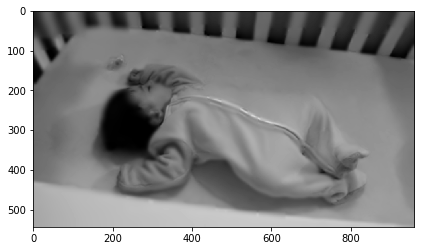

In [6]:
imshow(np.clip(reconstruct([np.nan_to_num(mag_pyr[level][30]) 
                            for level in range(LEVELS + 1)]), 0, 1))

In [7]:
output_frames = []
for i in range(len(frames) - 1):
    print(i)
    output_frames.append(np.clip(reconstruct([np.nan_to_num(mag_pyr[level][i])
                                              for level in range(LEVELS + 1)]), 0, 1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

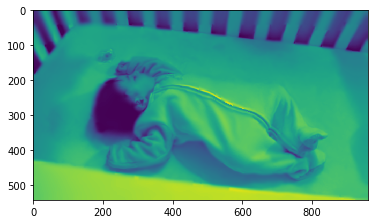

In [11]:
plt.imshow(output_frames[20])

In [8]:
writer = VideoWriter("out3.mp4", width, height)
for frame in output_frames:
    writer.write(frame)
writer.release()

In [86]:
import matplotlib.pyplot as plt
import numpy as np

In [92]:
x = np.arange(-3, 3, 0.5)

In [98]:
approx = 1 + x + x ** 2 / 2 + x ** 3 / 6 + x ** 4 / 24 + x ** 5 / 120
actual = np.exp(x)
approx2 = approx * (approx < 2) * (approx > -2)

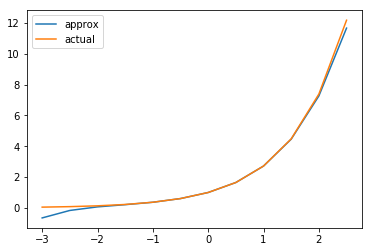

In [99]:
plt.plot(x, approx, label='approx')
plt.plot(x, actual, label='actual')
plt.legend(loc='best')

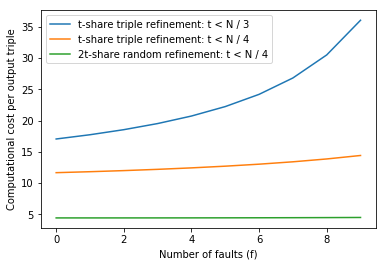

In [42]:
N = 32
# t = N / 3, N / 4
t = (N - 1) // 3
f = np.arange(0, t)
y = (N - f) * np.log(N - f) * 2 / (N - f - 2 * t + 1)
plt.plot(f, y, label=r't-share triple refinement: t < N / 3')

t = (N - 1) // 4
y = (N - f) * np.log(N - f) * 2 / (N - f - 2 * t + 1)
plt.plot(f, y, label=r't-share triple refinement: t < N / 4')

t = (N - 1) // 4
y = (N - f) * np.log(N - f) / (N - f - t)
plt.plot(f, y, label=r'2t-share random refinement: t < N / 4')

plt.xlabel("Number of faults (f)")
plt.ylabel("Computational cost per output triple")
plt.legend(loc='best')
plt.savefig('samarth.eps', bbox_inches='tight', format='eps')

In [77]:
import numpy as np
def prefix_sum(x, f):
    res = np.array(x)
    res[:] = x
    for i in range(int(np.ceil(np.log2(len(x))))):
        res[2 ** i:] = f(res[2 ** i:], res[:-2 ** i])
    return res

def binary_add(x, y):
    res = np.zeros_like(x)
    c = x * y
    d = x + y - 2 * c
    for i in range(int(np.ceil(np.log2(len(x))))):
        c[2 ** i:], d[2 ** i:] = c[2 ** i:] + (d[2 ** i:] * c[:-2 ** i]), d[2 ** i:] * d[:-2 ** i]
    
    res = x + y - 2 * c
    res[1:] += c[:-1]
    print(c)
    return res

def to_bits(x, n=5):
    res = [int(_) for _ in "{0:b}".format(x)][::-1]
    return np.array(res + ([0] * (n - len(res)) if n > len(res) else []))[:n]

def from_bits(x):
    return sum(x[i] * 2 ** i for i in range(len(x)))

In [78]:
to_bits(x, m)

array([1, 0, 1])

In [79]:
prefix_sum(np.ones(10), lambda x, y: x + y)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [80]:
x, y = 13, 1324
m = 3
print(from_bits(binary_add(to_bits(x, m), to_bits(y, m))))
print((x + y) % (2 ** m))

[0 0 1]
1
1


In [34]:
from_bits(binary_add(to_bits(7), to_bits(6)))

[0 1 1]


5

In [83]:
binary_add(np.array([1, 0, 1, 0, 1, 1]), np.array([1, 0, 0, 1, 1, 0]))

[1 0 0 0 1 1]


array([0, 1, 1, 1, 0, 0])